<a href="https://colab.research.google.com/github/mtedder/AudioAI-Project/blob/master/notebooks/audioai_playground.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Vinyl Audio QC AI/ML
This notebook documents most of the librosa library functions that may be needed to extract features to build a ML model to detect quality control defects in Vinyl records
The goal is detect the following audio QC metrics
*   Skips
*   Jumps
*   Sticks
*  Intrusive background noise





##1. Imports

In [0]:
#Create required directories
!mkdir annotations
!mkdir data
!mkdir sound_files

In [0]:
# Ref: https://librosa.github.io/librosa/index.html
import librosa
import librosa.display
import numpy as np

# Import the `pyplot` module
import matplotlib.pyplot as plt

##2. Data Preparation

###Load sample audio from file

In [0]:
# 2. Load the audio as a waveform `y`
#    Store the sampling rate as `sr`
SOUND_FILE = "sound_files/ramsey_lewis_maiden_voyage_trim.wav"
filename = SOUND_FILE
y, sr = librosa.load(filename)

###Load sample audio from library examples

In [0]:
# Alternate sound sample for testing examples
y, sr = librosa.load(librosa.util.example_audio_file(), offset=10, duration=15)

#librosa functions

##Spectral representations
[Core Ref:](https://librosa.github.io/librosa/core.html)

### stft
Short-time Fourier transform (STFT)

[Ref link](https://librosa.github.io/librosa/generated/librosa.core.stft.html#librosa-core-stft)

In [0]:
D = np.abs(librosa.stft(y))
D

In [0]:
# Display a spectrogram
librosa.display.specshow(librosa.amplitude_to_db(D,ref=np.max),y_axis='log', x_axis='time')
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()

### istft
Inverse short-time Fourier transform (ISTFT).

[Ref link](https://librosa.github.io/librosa/generated/librosa.core.istft.html#librosa-core-istft)

In [0]:
y_hat = librosa.istft(D)
y_hat

### ifgram
Compute the instantaneous frequency (as a proportion of the sampling rate) obtained as the time-derivative of the phase of the complex spectrum as described by [1].

[Ref link](https://librosa.github.io/librosa/generated/librosa.core.ifgram.html#librosa-core-ifgram)

In [0]:
frequencies, D = librosa.ifgram(y, sr=sr)
frequencies

### cqt
Compute the constant-Q transform of an audio signal.

[Ref link](https://librosa.github.io/librosa/generated/librosa.core.cqt.html#librosa-core-cqt)

In [0]:
C = np.abs(librosa.cqt(y, sr=sr))
librosa.display.specshow(librosa.amplitude_to_db(C, ref=np.max),
                        sr=sr, x_axis='time', y_axis='cqt_note')
plt.colorbar(format='%+2.0f dB')
plt.title('Constant-Q power spectrum')
plt.tight_layout()

### icqt
Compute the inverse constant-Q transform.

Given a constant-Q transform representation C of an audio signal y, this function produces an approximation y_hat.

[Ref link](https://librosa.github.io/librosa/generated/librosa.core.icqt.html#librosa-core-icqt)

In [0]:
C = librosa.cqt(y=y, sr=sr)
y_hat = librosa.icqt(C=C, sr=sr)

### hybrid_cqt
Compute the hybrid constant-Q transform of an audio signal.

Here, the hybrid CQT uses the pseudo CQT for higher frequencies where the hop_length is longer than half the filter length and the full CQT for lower frequencies.

[Ref link](https://librosa.github.io/librosa/generated/librosa.core.hybrid_cqt.html#librosa-core-hybrid-cqt)

In [0]:
C = librosa.hybrid_cqt(y=y, sr=sr)
C

### pseudo_cqt
Compute the pseudo constant-Q transform of an audio signal.

This uses a single fft size that is the smallest power of 2 that is greater than or equal to the max of:

1.  The longest CQT filter
2.   2x the hop_length

[Ref link](https://librosa.github.io/librosa/generated/librosa.core.pseudo_cqt.html#librosa-core-pseudo-cqt)

In [0]:
C = librosa.pseudo_cqt(y=y, sr=sr)
C

### iirt
Time-frequency representation using IIR filters [1].

This function will return a time-frequency representation using a multirate filter bank consisting of IIR filters. First, y is resampled as needed according to the provided sample_rates. Then, a filterbank with with n band-pass filters is designed. The resampled input signals are processed by the filterbank as a whole. (scipy.signal.filtfilt resp. sosfiltfilt is used to make the phase linear.) The output of the filterbank is cut into frames. For each band, the short-time mean-square power (STMSP) is calculated by summing win_length subsequent filtered time samples.

When called with the default set of parameters, it will generate the TF-representation as described in [1] (pitch filterbank):

        85 filters with MIDI pitches [24, 108] as center_freqs.
        each filter having a bandwith of one semitone.

[Ref link](https://librosa.github.io/librosa/generated/librosa.core.iirt.html#librosa-core-iirt)

In [0]:
D = np.abs(librosa.iirt(y))
librosa.display.specshow(librosa.amplitude_to_db(D, ref=np.max),
                       y_axis='cqt_hz', x_axis='time')
plt.title('Semitone spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()

### fmt
The fast Mellin transform (FMT) [1] of a uniformly sampled signal y.

When the Mellin parameter (beta) is 1/2, it is also known as the scale transform [2]. The scale transform can be useful for audio analysis because its magnitude is invariant to scaling of the domain (e.g., time stretching or compression). This is analogous to the magnitude of the Fourier transform being invariant to shifts in the input domain.

[Ref link](https://librosa.github.io/librosa/generated/librosa.core.fmt.html#librosa-core-fmt)


In [0]:
# Generate a signal and time-stretch it (with energy normalization)
scale = 1.25
freq = 3.0
x1 = np.linspace(0, 1, num=1024, endpoint=False)
x2 = np.linspace(0, 1, num=scale * len(x1), endpoint=False)
y1 = np.sin(2 * np.pi * freq * x1)
y2 = np.sin(2 * np.pi * freq * x2) / np.sqrt(scale)
# Verify that the two signals have the same energy
np.sum(np.abs(y1)**2), np.sum(np.abs(y2)**2)
# (255.99999999999997, 255.99999999999969)
scale1 = librosa.fmt(y1, n_fmt=512)
scale2 = librosa.fmt(y2, n_fmt=512)
# And plot the results
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(y1, label='Original')
plt.plot(y2, linestyle='--', label='Stretched')
plt.xlabel('time (samples)')
plt.title('Input signals')
plt.legend(frameon=True)
plt.axis('tight')
plt.subplot(1, 2, 2)
plt.semilogy(np.abs(scale1), label='Original')
plt.semilogy(np.abs(scale2), linestyle='--', label='Stretched')
plt.xlabel('scale coefficients')
plt.title('Scale transform magnitude')
plt.legend(frameon=True)
plt.axis('tight')
plt.tight_layout()

In [0]:
# Plot the scale transform of an onset strength autocorrelation
# y, sr = librosa.load(librosa.util.example_audio_file(),
#                       offset=10.0, duration=30.0)
odf = librosa.onset.onset_strength(y=y, sr=sr)
# Auto-correlate with up to 10 seconds lag
odf_ac = librosa.autocorrelate(odf, max_size=10 * sr // 512)
# Normalize
odf_ac = librosa.util.normalize(odf_ac, norm=np.inf)
# Compute the scale transform
odf_ac_scale = librosa.fmt(librosa.util.normalize(odf_ac), n_fmt=512)
# Plot the results
plt.figure()
plt.subplot(3, 1, 1)
plt.plot(odf, label='Onset strength')
plt.axis('tight')
plt.xlabel('Time (frames)')
plt.xticks([])
plt.legend(frameon=True)
plt.subplot(3, 1, 2)
plt.plot(odf_ac, label='Onset autocorrelation')
plt.axis('tight')
plt.xlabel('Lag (frames)')
plt.xticks([])
plt.legend(frameon=True)
plt.subplot(3, 1, 3)
plt.semilogy(np.abs(odf_ac_scale), label='Scale transform magnitude')
plt.axis('tight')
plt.xlabel('scale coefficients')
plt.legend(frameon=True)
plt.tight_layout()

### interp_harmonics
Compute the energy at harmonics of time-frequency representation.

Given a frequency-based energy representation such as a spectrogram or tempogram, this function computes the energy at the chosen harmonics of the frequency axis. (See examples below.) The resulting harmonic array can then be used as input to a salience computation.

[Ref link](https://librosa.github.io/librosa/generated/librosa.core.interp_harmonics.html#librosa-core-interp-harmonics)


In [0]:
# Compute the time-varying tempogram and average over time
tempi = np.mean(librosa.feature.tempogram(y=y, sr=sr), axis=1)
# We'll measure the first five harmonics
h_range = [1, 2, 3, 4, 5]
f_tempo = librosa.tempo_frequencies(len(tempi), sr=sr)
# Build the harmonic tensor
t_harmonics = librosa.interp_harmonics(tempi, f_tempo, h_range)
print(t_harmonics.shape)

plt.figure()
librosa.display.specshow(t_harmonics, x_axis='tempo', sr=sr)
plt.yticks(0.5 + np.arange(len(h_range)),
           ['{:.3g}'.format(_) for _ in h_range])
plt.ylabel('Harmonic')
plt.xlabel('Tempo (BPM)')
plt.tight_layout()



In [0]:
# We can also compute frequency harmonics for spectrograms. To calculate sub-harmonic energy, use values < 1.
h_range = [1./3, 1./2, 1, 2, 3, 4]
S = np.abs(librosa.stft(y))
fft_freqs = librosa.fft_frequencies(sr=sr)
S_harm = librosa.interp_harmonics(S, fft_freqs, h_range, axis=0)
print(S_harm.shape)

plt.figure()
for i, _sh in enumerate(S_harm, 1):
  plt.subplot(3, 2, i)
  librosa.display.specshow(librosa.amplitude_to_db(_sh,ref=S.max()), sr=sr, y_axis='log')
  plt.title('h={:.3g}'.format(h_range[i-1]))
plt.tight_layout()

### salience
Harmonic salience function.

[Ref link](https://librosa.github.io/librosa/generated/librosa.core.salience.html#librosa-core-salience)

In [0]:
# y, sr = librosa.load(librosa.util.example_audio_file(),
#                      duration=15, offset=30)
S = np.abs(librosa.stft(y))
freqs = librosa.core.fft_frequencies(sr)
harms = [1, 2, 3, 4]
weights = [1.0, 0.5, 0.33, 0.25]
S_sal = librosa.salience(S, freqs, harms, weights, fill_value=0)
print(S_sal.shape)

plt.figure()
librosa.display.specshow(librosa.amplitude_to_db(S_sal,
                                                  ref=np.max),
                          sr=sr, y_axis='log', x_axis='time')
plt.colorbar()
plt.title('Salience spectrogram')
plt.tight_layout()

### phase_vocoder
Phase vocoder. Given an STFT matrix D, speed up by a factor of rate

Based on the implementation provided by [1].

[Ref link](https://librosa.github.io/librosa/generated/librosa.core.phase_vocoder.html#librosa-core-phase-vocoder)

In [0]:
# Play at double speed
D = librosa.stft(y, n_fft=2048, hop_length=512)
D_fast  = librosa.phase_vocoder(D, 2.0, hop_length=512)
y_fast  = librosa.istft(D_fast, hop_length=512)

In [0]:
# Or play at 1/3 speed
D = librosa.stft(y, n_fft=2048, hop_length=512)
D_slow  = librosa.phase_vocoder(D, 1./3, hop_length=512)
y_slow  = librosa.istft(D_slow, hop_length=512)

### magphase
Separate a complex-valued spectrogram D into its magnitude (S) and phase (P) components, so that D = S * P.

[Ref link](https://librosa.github.io/librosa/generated/librosa.core.magphase.html#librosa-core-magphase)

In [0]:
D = librosa.stft(y)
magnitude, phase = librosa.magphase(D)
magnitude

In [0]:
# Or get the phase angle (in radians)
np.angle(phase)

##Magnitude scaling

[Ref link](https://librosa.github.io/librosa/core.html#magnitude-scaling)

###amplitude_to_db

[Ref link](https://librosa.github.io/librosa/generated/librosa.core.amplitude_to_db.html#librosa-core-amplitude-to-db)
Convert an amplitude spectrogram to dB-scaled spectrogram.

This is equivalent to power_to_db(S**2), but is provided for convenience.

In [0]:
S = np.abs(librosa.stft(y))
librosa.amplitude_to_db(S**2)

###db_to_amplitude

[Ref link](https://librosa.github.io/librosa/generated/librosa.core.db_to_amplitude.html#librosa-core-db-to-amplitude)

Convert a dB-scaled spectrogram to an amplitude spectrogram.

This effectively inverts amplitude_to_db:

    db_to_amplitude(S_db) ~= 10.0**(0.5 * (S_db + log10(ref)/10))

In [0]:
S = np.abs(librosa.stft(y))
S_db = librosa.amplitude_to_db(S**2)
librosa.db_to_amplitude(S_db)

###power_to_db
[Ref link](https://librosa.github.io/librosa/generated/librosa.core.power_to_db.html#librosa-core-power-to-db)

Convert a power spectrogram (amplitude squared) to decibel (dB) units

This computes the scaling 10 * log10(S / ref) in a numerically stable way.

In [0]:
S = np.abs(librosa.stft(y))
librosa.power_to_db(S**2)

###db_to_power
[Ref link](https://librosa.github.io/librosa/generated/librosa.core.db_to_power.html#librosa-core-db-to-power)

Convert a dB-scale spectrogram to a power spectrogram.

This effectively inverts power_to_db:

    db_to_power(S_db) ~= ref * 10.0**(S_db / 10)

In [0]:
S = np.abs(librosa.stft(y))
S_db = librosa.power_to_db(S**2)
librosa.db_to_power(S_db) 

###perceptual_weighting
[Ref link](https://librosa.github.io/librosa/generated/librosa.core.perceptual_weighting.html#librosa-core-perceptual-weighting)

Perceptual weighting of a power spectrogram:

S_p[f] = A_weighting(f) + 10*log(S[f] / ref)

In [0]:
C = np.abs(librosa.cqt(y, sr=sr, fmin=librosa.note_to_hz('A1')))
freqs = librosa.cqt_frequencies(C.shape[0],fmin=librosa.note_to_hz('A1'))
perceptual_CQT = librosa.perceptual_weighting(C**2,freqs,ref=np.max)
perceptual_CQT

In [0]:
plt.figure()
plt.subplot(2, 1, 1)
librosa.display.specshow(librosa.amplitude_to_db(C,
                                                  ref=np.max),
                          fmin=librosa.note_to_hz('A1'),
                          y_axis='cqt_hz')
plt.title('Log CQT power')
plt.colorbar(format='%+2.0f dB')
plt.subplot(2, 1, 2)
librosa.display.specshow(perceptual_CQT, y_axis='cqt_hz',
                          fmin=librosa.note_to_hz('A1'),
                          x_axis='time')
plt.title('Perceptually weighted log CQT')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()

###A_weighting
[Ref link](https://librosa.github.io/librosa/generated/librosa.core.A_weighting.html#librosa-core-a-weighting)

Compute the A-weighting of a set of frequencies.



In [0]:
freqs = librosa.cqt_frequencies(108, librosa.note_to_hz('C1'))
aw = librosa.A_weighting(freqs)
plt.plot(freqs, aw)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Weighting (log10)')
plt.title('A-Weighting of CQT frequencies')

###core.pcen
[Ref link](https://librosa.github.io/librosa/generated/librosa.core.pcen.html#librosa-core-pcen)

Per-channel energy normalization (PCEN) [1]

This function normalizes a time-frequency representation S by performing automatic gain control, followed by nonlinear compression:

    P[f, t] = (S / (eps + M[f, t])**gain + bias)**power - bias**power

where M is the result of applying a low-pass, temporal IIR filter to S:

    M[f, t] = (1 - b) * M[f, t - 1] + b * S[f, t]

If b is not provided, it is calculated as:

    b = (sqrt(1 + 4* T**2) - 1) / (2 * T**2)

where T = time_constant * sr / hop_length.

This normalization is designed to suppress background noise and emphasize foreground signals, and can be used as an alternative to decibel scaling (amplitude_to_db).

This implementation also supports smoothing across frequency bins by specifying max_size > 1. If this option is used, the filtered spectrogram M is computed as

    M[f, t] = (1 - b) * M[f, t - 1] + b * R[f, t]

where R has been max-filtered along the frequency axis, similar to the SuperFlux algorithm implemented in onset.onset_strength:

    R[f, t] = max(S[f - max_size//2: f + max_size//2, t])

This can be used to perform automatic gain control on signals that cross or span multiple frequency bans, which may be desirable for spectrograms with high frequency resolution.

In [0]:
# We'll use power=1 to get a magnitude spectrum
# instead of a power spectrum
S = librosa.feature.melspectrogram(y, sr=sr, power=1)
log_S = librosa.amplitude_to_db(S, ref=np.max)
pcen_S = librosa.pcen(S)
plt.figure()
plt.subplot(2,1,1)
librosa.display.specshow(log_S, x_axis='time', y_axis='mel')
plt.title('log amplitude (dB)')
plt.colorbar()
plt.subplot(2,1,2)
librosa.display.specshow(pcen_S, x_axis='time', y_axis='mel')
plt.title('Per-channel energy normalization')
plt.colorbar()
plt.tight_layout()

In [0]:
pcen_max = librosa.pcen(S, max_size=3)
plt.figure()
plt.subplot(2,1,1)
librosa.display.specshow(pcen_S, x_axis='time', y_axis='mel')
plt.title('Per-channel energy normalization (no max-filter)')
plt.colorbar()
plt.subplot(2,1,2)
librosa.display.specshow(pcen_max, x_axis='time', y_axis='mel')
plt.title('Per-channel energy normalization (max_size=3)')
plt.colorbar()
plt.tight_layout()

##Time and frequency conversion
[Ref link](https://librosa.github.io/librosa/core.html#time-and-frequency-conversion)

###frames_to_samples
[Ref link](https://librosa.github.io/librosa/generated/librosa.core.frames_to_samples.html#librosa-core-frames-to-samples)

Converts frame indices to audio sample indices.

In [0]:
tempo, beats = librosa.beat.beat_track(y, sr=sr)
beat_samples = librosa.frames_to_samples(beats)
beat_samples


###frames_to_time
[Ref link](https://librosa.github.io/librosa/generated/librosa.core.frames_to_time.html#librosa-core-frames-to-time)

Converts frame counts to time (seconds).

In [0]:
tempo, beats = librosa.beat.beat_track(y, sr=sr)
beat_times = librosa.frames_to_time(beats, sr=sr)
beat_times

###samples_to_frames
[Ref link](https://librosa.github.io/librosa/generated/librosa.core.samples_to_frames.html#librosa-core-samples-to-frames)

Converts sample indices into STFT frames.

In [0]:
 # Get the frame numbers for every 256 samples
librosa.samples_to_frames(np.arange(0, 22050, 256))

###samples_to_time
[Ref link](https://librosa.github.io/librosa/generated/librosa.core.samples_to_time.html#librosa-core-samples-to-time)

Convert sample indices to time (in seconds).

In [0]:
librosa.samples_to_time(np.arange(0, 22050, 512))

###time_to_frames
[Ref link](https://librosa.github.io/librosa/generated/librosa.core.time_to_frames.html#librosa-core-time-to-frames)

Converts time stamps into STFT frames.

In [0]:
librosa.time_to_frames(np.arange(0, 1, 0.1),sr=22050, hop_length=512)

###time_to_samples
[Ref link](https://librosa.github.io/librosa/generated/librosa.core.time_to_samples.html#librosa-core-time-to-samples)

Convert timestamps (in seconds) to sample indices.

In [0]:
librosa.time_to_samples(np.arange(0, 1, 0.1), sr=22050)

###hz_to_note
[Ref link](https://librosa.github.io/librosa/generated/librosa.core.hz_to_note.html#librosa-core-hz-to-note)

Convert one or more frequencies (in Hz) to the nearest note names.

In [0]:
librosa.hz_to_note(440.0)

###hz_to_midi
[Ref link](https://librosa.github.io/librosa/generated/librosa.core.hz_to_midi.html#librosa-core-hz-to-midi)

Get MIDI note number(s) for given frequencies

In [0]:
librosa.hz_to_midi(60)

###midi_to_hz
[Ref link](https://librosa.github.io/librosa/generated/librosa.core.midi_to_hz.html#librosa-core-midi-to-hz)

Get the frequency (Hz) of MIDI note(s)


###midi_to_note
[Ref link](https://librosa.github.io/librosa/generated/librosa.core.midi_to_note.html#librosa-core-midi-to-note)

Convert one or more MIDI numbers to note strings.

MIDI numbers will be rounded to the nearest integer.

Notes will be of the format ‘C0’, ‘C#0’, ‘D0’, …

In [0]:
note = librosa.midi_to_note(0)
print(note)

note = librosa.midi_to_note(37)
print(note)

note = librosa.midi_to_note(-2)
print(note)

###note_to_hz
[Ref link](https://librosa.github.io/librosa/generated/librosa.core.note_to_hz.html#librosa-core-note-to-hz)

Convert one or more note names to frequency (Hz)

In [0]:
# Get the frequency of a note
librosa.note_to_hz('C')

# Or multiple notes
librosa.note_to_hz(['A3', 'A4', 'A5'])

# Or notes with tuning deviations
librosa.note_to_hz('C2-32', round_midi=False)


###note_to_midi
[Ref link](https://librosa.github.io/librosa/generated/librosa.core.note_to_midi.html#librosa-core-note-to-midi)

Convert one or more spelled notes to MIDI number(s).

Notes may be spelled out with optional accidentals or octave numbers.

The leading note name is case-insensitive.

Sharps are indicated with #, flats may be indicated with ! or b.

In [0]:
librosa.note_to_midi('C')

###hz_to_mel
[Ref link](https://librosa.github.io/librosa/generated/librosa.core.hz_to_mel.html#librosa-core-hz-to-mel)

Convert Hz to Mels

In [0]:
librosa.hz_to_mel(60)

###hz_to_octs
[Ref link](https://librosa.github.io/librosa/generated/librosa.core.hz_to_octs.html#librosa-core-hz-to-octs)

Convert frequencies (Hz) to (fractional) octave numbers.

In [0]:
librosa.hz_to_octs(440.0)

###mel_to_hz
[Ref link](https://librosa.github.io/librosa/generated/librosa.core.mel_to_hz.html#librosa-core-mel-to-hz)

Convert mel bin numbers to frequencies

In [0]:
librosa.mel_to_hz(3)

###octs_to_hz
[Ref](https://librosa.github.io/librosa/generated/librosa.core.octs_to_hz.html#librosa-core-octs-to-hz)

Convert octaves numbers to frequencies.

Octaves are counted relative to A.

In [0]:
librosa.octs_to_hz(1)

###fft_frequencies
[Ref link](https://librosa.github.io/librosa/generated/librosa.core.fft_frequencies.html#librosa-core-fft-frequencies)

Alternative implementation of np.fft.fftfreq

In [0]:
librosa.fft_frequencies(sr=22050, n_fft=16)

###cqt_frequencies
[Ref link](https://librosa.github.io/librosa/generated/librosa.core.cqt_frequencies.html#librosa-core-cqt-frequencies)

Compute the center frequencies of Constant-Q bins.

In [0]:
# Get the CQT frequencies for 24 notes, starting at C2
librosa.cqt_frequencies(24, fmin=librosa.note_to_hz('C2'))

###mel_frequencies
[Ref link](https://librosa.github.io/librosa/generated/librosa.core.mel_frequencies.html#librosa-core-mel-frequencies)

Compute an array of acoustic frequencies tuned to the mel scale.

The mel scale is a quasi-logarithmic function of acoustic frequency designed such that perceptually similar pitch intervals (e.g. octaves) appear equal in width over the full hearing range.

Because the definition of the mel scale is conditioned by a finite number of subjective psychoaoustical experiments, several implementations coexist in the audio signal processing literature [1]. By default, librosa replicates the behavior of the well-established MATLAB Auditory Toolbox of Slaney [2]. According to this default implementation, the conversion from Hertz to mel is linear below 1 kHz and logarithmic above 1 kHz. Another available implementation replicates the Hidden Markov Toolkit [3] (HTK) according to the following formula:

mel = 2595.0 * np.log10(1.0 + f / 700.0).

The choice of implementation is determined by the htk keyword argument: setting htk=False leads to the Auditory toolbox implementation, whereas setting it htk=True leads to the HTK implementation.

In [0]:
librosa.mel_frequencies(n_mels=40)

###tempo_frequencies
[Ref link](https://librosa.github.io/librosa/generated/librosa.core.tempo_frequencies.html#librosa-core-tempo-frequencies)

Compute the frequencies (in beats-per-minute) corresponding to an onset auto-correlation or tempogram matrix.

In [0]:
librosa.tempo_frequencies(384)

###samples_like
[Ref link](https://librosa.github.io/librosa/generated/librosa.core.samples_like.html#librosa-core-samples-like)

Return an array of sample indices to match the time axis from a feature matrix.

In [0]:
X = librosa.stft(y)
samples = librosa.samples_like(X)
samples

###times_like
[Ref link](https://librosa.github.io/librosa/generated/librosa.core.times_like.html#librosa-core-times-like)

Return an array of time values to match the time axis from a feature matrix.

In [0]:
# Provide a feature matrix input:
X = librosa.stft(y)
times = librosa.times_like(X)
times

In [0]:
# Provide a scalar input:
n_frames = 2647
times = librosa.times_like(n_frames)
times

##Pitch and tuning
[Ref link](https://librosa.github.io/librosa/core.html#pitch-and-tuning)

###estimate_tuning
[Ref link](https://librosa.github.io/librosa/generated/librosa.core.estimate_tuning.html#librosa-core-estimate-tuning)

Estimate the tuning of an audio time series or spectrogram input.

In [0]:
# With time-series input
librosa.estimate_tuning(y=y, sr=sr)

In [0]:
# In tenths of a cent
librosa.estimate_tuning(y=y, sr=sr, resolution=1e-3)

In [0]:
# Using spectrogram input
S = np.abs(librosa.stft(y))
librosa.estimate_tuning(S=S, sr=sr)

In [0]:
# Using pass-through arguments to `librosa.piptrack`
librosa.estimate_tuning(y=y, sr=sr, n_fft=8192,fmax=librosa.note_to_hz('G#9'))

###pitch_tuning
[Ref link](https://librosa.github.io/librosa/generated/librosa.core.pitch_tuning.html#librosa-core-pitch-tuning)

Given a collection of pitches, estimate its tuning offset (in fractions of a bin) relative to A440=440.0Hz.

In [0]:
# Generate notes at +25 cents
freqs = librosa.cqt_frequencies(24, 55, tuning=0.25)
librosa.pitch_tuning(freqs)

In [0]:
# Track frequencies from a real spectrogram
pitches, magnitudes, stft = librosa.ifptrack(y, sr)
# Select out pitches with high energy
pitches = pitches[magnitudes > np.median(magnitudes)]
librosa.pitch_tuning(pitches)

###piptrack
[Ref link](https://librosa.github.io/librosa/generated/librosa.core.piptrack.html#librosa-core-piptrack)

Pitch tracking on thresholded parabolically-interpolated STFT.

This implementation uses the parabolic interpolation method described by [1].

In [0]:
pitches, magnitudes = librosa.piptrack(y=y, sr=sr)
print(pitches)
print(magnitudes)

##Spectral features

[Ref link](https://librosa.github.io/librosa/feature.html#spectral-features)

###chroma_stft
[Ref link](https://librosa.github.io/librosa/generated/librosa.feature.chroma_stft.html#librosa-feature-chroma-stft)

Compute a chromagram from a waveform or power spectrogram.

This implementation is derived from chromagram_E [1]

In [0]:
librosa.feature.chroma_stft(y=y, sr=sr)

In [0]:
S = np.abs(librosa.stft(y))
chroma = librosa.feature.chroma_stft(S=S, sr=sr)
chroma

In [0]:
S = np.abs(librosa.stft(y, n_fft=4096))**2
chroma = librosa.feature.chroma_stft(S=S, sr=sr)
chroma

In [0]:
plt.figure(figsize=(10, 4))
librosa.display.specshow(chroma, y_axis='chroma', x_axis='time')
plt.colorbar()
plt.title('Chromagram')
plt.tight_layout()

###chroma_cqt

[Ref](https://librosa.github.io/librosa/generated/librosa.feature.chroma_cqt.html#librosa-feature-chroma-cqt)

Constant-Q chromagram

In [0]:
chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr,
                                           n_chroma=12, n_fft=4096)
chroma_cq = librosa.feature.chroma_cqt(y=y, sr=sr)

In [0]:
plt.figure()
plt.subplot(2,1,1)
librosa.display.specshow(chroma_stft, y_axis='chroma')
plt.title('chroma_stft')
plt.colorbar()
plt.subplot(2,1,2)
librosa.display.specshow(chroma_cq, y_axis='chroma', x_axis='time')
plt.title('chroma_cqt')
plt.colorbar()
plt.tight_layout()

###chroma_cens

[Ref link](https://librosa.github.io/librosa/generated/librosa.feature.chroma_cens.html#librosa-feature-chroma-cens)

Computes the chroma variant “Chroma Energy Normalized” (CENS), following [1].

To compute CENS features, following steps are taken after obtaining chroma vectors using chroma_cqt: 1. L-1 normalization of each chroma vector 2. Quantization of amplitude based on “log-like” amplitude thresholds 3. (optional) Smoothing with sliding window. Default window length = 41 frames 4. (not implemented) Downsampling

CENS features are robust to dynamics, timbre and articulation, thus these are commonly used in audio matching and retrieval applications.

In [0]:
chroma_cens = librosa.feature.chroma_cens(y=y, sr=sr)
chroma_cq = librosa.feature.chroma_cqt(y=y, sr=sr)

In [0]:
plt.figure()
plt.subplot(2,1,1)
librosa.display.specshow(chroma_cq, y_axis='chroma')
plt.title('chroma_cq')
plt.colorbar()
plt.subplot(2,1,2)
librosa.display.specshow(chroma_cens, y_axis='chroma', x_axis='time')
plt.title('chroma_cens')
plt.colorbar()
plt.tight_layout()

###melspectrogram

[Ref link](https://librosa.github.io/librosa/generated/librosa.feature.melspectrogram.html#librosa-feature-melspectrogram)

Compute a mel-scaled spectrogram.

If a spectrogram input S is provided, then it is mapped directly onto the mel basis mel_f by mel_f.dot(S).

If a time-series input y, sr is provided, then its magnitude spectrogram S is first computed, and then mapped onto the mel scale by mel_f.dot(S**power). By default, power=2 operates on a power spectrum.

In [0]:
librosa.feature.melspectrogram(y=y, sr=sr)

In [0]:
D = np.abs(librosa.stft(y))**2
S = librosa.feature.melspectrogram(S=D)

In [0]:
 # Passing through arguments to the Mel filters
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128,fmax=8000)

In [0]:
plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.power_to_db(S,ref=np.max),
                          y_axis='mel', fmax=8000,
                          x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram')
plt.tight_layout()

###mfcc

[Ref link](https://librosa.github.io/librosa/generated/librosa.feature.mfcc.html#librosa-feature-mfcc)

Mel-frequency cepstral coefficients (MFCCs)

In [0]:
librosa.feature.mfcc(y=y, sr=sr)

In [0]:
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128,fmax=8000)
librosa.feature.mfcc(S=librosa.power_to_db(S))

array([[-4.93662969e+02, -3.78776724e+02, -3.09925575e+02, ...,
        -5.77576017e+02, -5.74887314e+02, -5.58614138e+02],
       [ 4.60761197e+01,  4.86620486e+01,  5.11118235e+01, ...,
         5.22791506e+01,  5.57176079e+01,  4.06147386e+01],
       [-1.20147020e+01, -3.98871872e+01, -5.15142819e+01, ...,
         4.05057165e+01,  4.20550063e+01,  3.96028380e+01],
       ...,
       [ 4.13594952e+00,  3.52819947e+00, -2.02149448e+00, ...,
         9.04315548e+00,  4.51733474e+00,  5.52798160e+00],
       [ 4.73516421e+00,  4.25929610e+00, -2.17193158e+00, ...,
         8.13875032e+00,  3.75621436e+00,  6.37534635e+00],
       [-5.33135079e+00,  3.16846940e+00, -2.50064625e-01, ...,
         4.28375381e+00,  5.76965027e+00,  5.95774805e+00]])

In [0]:
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)

In [0]:
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfccs, x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()

In [0]:
m_slaney = librosa.feature.mfcc(y=y, sr=sr, dct_type=2)
m_htk = librosa.feature.mfcc(y=y, sr=sr, dct_type=3)
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
librosa.display.specshow(m_slaney, x_axis='time')
plt.title('RASTAMAT / Auditory toolbox (dct_type=2)')
plt.colorbar()
plt.subplot(2, 1, 2)
librosa.display.specshow(m_htk, x_axis='time')
plt.title('HTK-style (dct_type=3)')
plt.colorbar()
plt.tight_layout()

###rms

[Ref link](https://librosa.github.io/librosa/generated/librosa.feature.rms.html#librosa-feature-rms)

Compute root-mean-square (RMS) value for each frame, either from the audio samples y or from a spectrogram S.

Computing the RMS value from audio samples is faster as it doesn’t require a STFT calculation. However, using a spectrogram will give a more accurate representation of energy over time because its frames can be windowed, thus prefer using S if it’s already available.

In [0]:
librosa.feature.rms(y=y)

array([[0.0025118 , 0.00359596, 0.00369645, ..., 0.00689465, 0.00715862,
        0.00793121]], dtype=float32)

In [0]:
S, phase = librosa.magphase(librosa.stft(y))
rms = librosa.feature.rms(S=S)

In [0]:
plt.figure()
plt.subplot(2, 1, 1)
plt.semilogy(rms.T, label='RMS Energy')
plt.xticks([])
plt.xlim([0, rms.shape[-1]])
plt.legend(loc='best')
plt.subplot(2, 1, 2)
librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max),y_axis='log', x_axis='time')
plt.title('log Power spectrogram')
plt.tight_layout()

In [0]:
# Use a STFT window of constant ones and no frame centering to get consistent results with the RMS computed from the audio samples y
S = librosa.magphase(librosa.stft(y, window=np.ones, center=False))[0]
librosa.feature.rms(S=S)

###rmse

[Ref link](https://librosa.github.io/librosa/generated/librosa.feature.rmse.html#librosa-feature-rmse)

Compute root-mean-square (RMS) value for each frame, either from the audio samples y or from a spectrogram S.

Computing the RMS value from audio samples is faster as it doesn’t require a STFT calculation. However, using a spectrogram will give a more accurate representation of energy over time because its frames can be windowed, thus prefer using S if it’s already available.

In [0]:
librosa.feature.rms(y=y)

In [0]:
S, phase = librosa.magphase(librosa.stft(y))
rms = librosa.feature.rms(S=S)

In [0]:
plt.figure()
plt.subplot(2, 1, 1)
plt.semilogy(rms.T, label='RMS Energy')
plt.xticks([])
plt.xlim([0, rms.shape[-1]])
plt.legend(loc='best')
plt.subplot(2, 1, 2)
librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max),y_axis='log', x_axis='time')
plt.title('log Power spectrogram')
plt.tight_layout()

In [0]:
S = librosa.magphase(librosa.stft(y, window=np.ones, center=False))[0]
librosa.feature.rms(S=S)

###spectral_centroid

[Ref link](https://librosa.github.io/librosa/generated/librosa.feature.spectral_centroid.html#librosa-feature-spectral-centroid)

Compute the spectral centroid.

Each frame of a magnitude spectrogram is normalized and treated as a distribution over frequency bins, from which the mean (centroid) is extracted per frame.

In [0]:
cent = librosa.feature.spectral_centroid(y=y, sr=sr)
cent

In [0]:
S, phase = librosa.magphase(librosa.stft(y=y))
librosa.feature.spectral_centroid(S=S)

In [0]:
if_gram, D = librosa.ifgram(y)
librosa.feature.spectral_centroid(S=np.abs(D), freq=if_gram)

In [0]:
plt.figure()
plt.subplot(2, 1, 1)
plt.semilogy(cent.T, label='Spectral centroid')
plt.ylabel('Hz')
plt.xticks([])
plt.xlim([0, cent.shape[-1]])
plt.legend()
plt.subplot(2, 1, 2)
librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max),y_axis='log', x_axis='time')
plt.title('log Power spectrogram')
plt.tight_layout()

###spectral_bandwidth

[Ref link](https://librosa.github.io/librosa/generated/librosa.feature.spectral_bandwidth.html#librosa-feature-spectral-bandwidth)

Compute p’th-order spectral bandwidth:

(sum_k S[k] * (freq[k] - centroid)**p)**(1/p)

In [0]:
spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
spec_bw

In [0]:
S, phase = librosa.magphase(librosa.stft(y=y))
librosa.feature.spectral_bandwidth(S=S)

In [0]:
if_gram, D = librosa.ifgram(y)
librosa.feature.spectral_bandwidth(S=np.abs(D), freq=if_gram)

In [0]:
plt.figure()
plt.subplot(2, 1, 1)
plt.semilogy(spec_bw.T, label='Spectral bandwidth')
plt.ylabel('Hz')
plt.xticks([])
plt.xlim([0, spec_bw.shape[-1]])
plt.legend()
plt.subplot(2, 1, 2)
librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max), y_axis='log', x_axis='time')
plt.title('log Power spectrogram')
plt.tight_layout()

###spectral_contrast

[Ref link](https://librosa.github.io/librosa/generated/librosa.feature.spectral_contrast.html#librosa-feature-spectral-contrast)

Compute spectral contrast [1]

In [0]:
S = np.abs(librosa.stft(y))
contrast = librosa.feature.spectral_contrast(S=S, sr=sr)

In [0]:
plt.figure()
plt.subplot(2, 1, 1)
librosa.display.specshow(librosa.amplitude_to_db(S,ref=np.max),y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Power spectrogram')
plt.subplot(2, 1, 2)
librosa.display.specshow(contrast, x_axis='time')
plt.colorbar()
plt.ylabel('Frequency bands')
plt.title('Spectral contrast')
plt.tight_layout()

###spectral_flatness

[Ref link](https://librosa.github.io/librosa/generated/librosa.feature.spectral_flatness.html#librosa-feature-spectral-flatness)

Compute spectral flatness

Spectral flatness (or tonality coefficient) is a measure to quantify how much noise-like a sound is, as opposed to being tone-like [1]. A high spectral flatness (closer to 1.0) indicates the spectrum is similar to white noise. It is often converted to decibel.

In [0]:
flatness = librosa.feature.spectral_flatness(y=y)
flatness

In [0]:
S, phase = librosa.magphase(librosa.stft(y))
librosa.feature.spectral_flatness(S=S)

In [0]:
S, phase = librosa.magphase(librosa.stft(y))
S_power = S ** 2
librosa.feature.spectral_flatness(S=S_power, power=1.0)

###spectral_rolloff

[Ref link](https://librosa.github.io/librosa/generated/librosa.feature.spectral_rolloff.html#librosa-feature-spectral-rolloff)

Compute roll-off frequency.

The roll-off frequency is defined for each frame as the center frequency for a spectrogram bin such that at least roll_percent (0.85 by default) of the energy of the spectrum in this frame is contained in this bin and the bins below. This can be used to, e.g., approximate the maximum (or minimum) frequency by setting roll_percent to a value close to 1 (or 0).

In [0]:
# Approximate maximum frequencies with roll_percent=0.85 (default)
rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
rolloff

# Approximate minimum frequencies with roll_percent=0.1
rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr, roll_percent=0.1)
rolloff

In [0]:
# From spectrogram input
S, phase = librosa.magphase(librosa.stft(y))
librosa.feature.spectral_rolloff(S=S, sr=sr)

In [0]:
# With a higher roll percentage:
librosa.feature.spectral_rolloff(y=y, sr=sr, roll_percent=0.95)

In [0]:
plt.figure()
plt.subplot(2, 1, 1)
plt.semilogy(rolloff.T, label='Roll-off frequency')
plt.ylabel('Hz')
plt.xticks([])
plt.xlim([0, rolloff.shape[-1]])
plt.legend()
plt.subplot(2, 1, 2)
librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max), y_axis='log', x_axis='time')
plt.title('log Power spectrogram')
plt.tight_layout()


###poly_features

[Ref link](https://librosa.github.io/librosa/generated/librosa.feature.poly_features.html#librosa-feature-poly-features)

Get coefficients of fitting an nth-order polynomial to the columns of a spectrogram.

In [0]:
S = np.abs(librosa.stft(y))

In [0]:
# Fit a degree-0 polynomial (constant) to each frame
p0 = librosa.feature.poly_features(S=S, order=0)

In [0]:
# Fit a linear polynomial to each frame
p1 = librosa.feature.poly_features(S=S, order=1)

In [0]:
# Fit a quadratic to each frame
p2 = librosa.feature.poly_features(S=S, order=2)

In [0]:
# Plot the results for comparison
plt.figure(figsize=(8, 8))
ax = plt.subplot(4,1,1)
plt.plot(p2[2], label='order=2', alpha=0.8)
plt.plot(p1[1], label='order=1', alpha=0.8)
plt.plot(p0[0], label='order=0', alpha=0.8)
plt.xticks([])
plt.ylabel('Constant')
plt.legend()
plt.subplot(4,1,2, sharex=ax)
plt.plot(p2[1], label='order=2', alpha=0.8)
plt.plot(p1[0], label='order=1', alpha=0.8)
plt.xticks([])
plt.ylabel('Linear')
plt.subplot(4,1,3, sharex=ax)
plt.plot(p2[0], label='order=2', alpha=0.8)
plt.xticks([])
plt.ylabel('Quadratic')
plt.subplot(4,1,4, sharex=ax)
librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max),y_axis='log')
plt.tight_layout()

###tonnetz

[Ref link](Computes the tonal centroid features (tonnetz), following the method of [1].)

Computes the tonal centroid features (tonnetz), following the method of [1].

###zero_crossing_rate

[Ref link](https://librosa.github.io/librosa/generated/librosa.feature.zero_crossing_rate.html#librosa-feature-zero-crossing-rate)

Compute the zero-crossing rate of an audio time series.

In [0]:
librosa.feature.zero_crossing_rate(y)

##Rhythm features

[Ref link](https://librosa.github.io/librosa/feature.html#rhythm-features)

###tempogram

[Ref link](https://librosa.github.io/librosa/generated/librosa.feature.tempogram.html#librosa-feature-tempogram)

Compute the tempogram: local autocorrelation of the onset strength envelope. [1]

In [0]:
hop_length = 512
oenv = librosa.onset.onset_strength(y=y, sr=sr, hop_length=hop_length)
tempogram = librosa.feature.tempogram(onset_envelope=oenv, sr=sr,hop_length=hop_length)
# Compute global onset autocorrelation
ac_global = librosa.autocorrelate(oenv, max_size=tempogram.shape[0])
ac_global = librosa.util.normalize(ac_global)
# Estimate the global tempo for display purposes
tempo = librosa.beat.tempo(onset_envelope=oenv, sr=sr,hop_length=hop_length)[0]

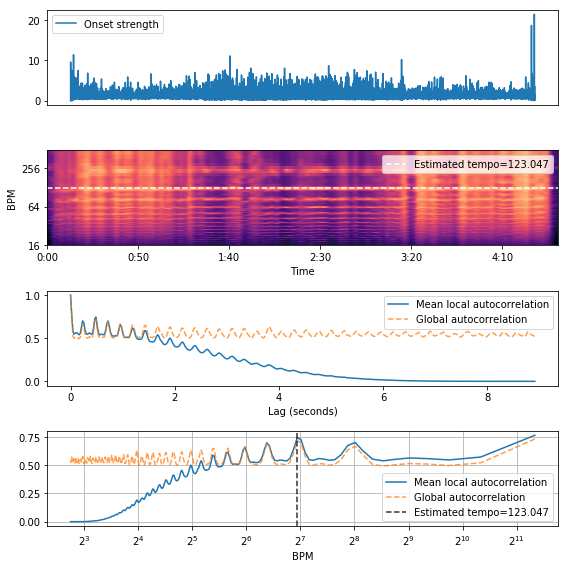

In [0]:
plt.figure(figsize=(8, 8))
plt.subplot(4, 1, 1)
plt.plot(oenv, label='Onset strength')
plt.xticks([])
plt.legend(frameon=True)
plt.axis('tight')
plt.subplot(4, 1, 2)
# We'll truncate the display to a narrower range of tempi
librosa.display.specshow(tempogram, sr=sr, hop_length=hop_length,
                          x_axis='time', y_axis='tempo')
plt.axhline(tempo, color='w', linestyle='--', alpha=1,
             label='Estimated tempo={:g}'.format(tempo))
plt.legend(frameon=True, framealpha=0.75)
plt.subplot(4, 1, 3)
x = np.linspace(0, tempogram.shape[0] * float(hop_length) / sr,
                num=tempogram.shape[0])
plt.plot(x, np.mean(tempogram, axis=1), label='Mean local autocorrelation')
plt.plot(x, ac_global, '--', alpha=0.75, label='Global autocorrelation')
plt.xlabel('Lag (seconds)')
plt.axis('tight')
plt.legend(frameon=True)
plt.subplot(4,1,4)
# We can also plot on a BPM axis
freqs = librosa.tempo_frequencies(tempogram.shape[0], hop_length=hop_length, sr=sr)
plt.semilogx(freqs[1:], np.mean(tempogram[1:], axis=1),
              label='Mean local autocorrelation', basex=2)
plt.semilogx(freqs[1:], ac_global[1:], '--', alpha=0.75,
              label='Global autocorrelation', basex=2)
plt.axvline(tempo, color='black', linestyle='--', alpha=.8,
             label='Estimated tempo={:g}'.format(tempo))
plt.legend(frameon=True)
plt.xlabel('BPM')
plt.axis('tight')
plt.grid()
plt.tight_layout()

##Feature manipulation

[Ref link](https://librosa.github.io/librosa/feature.html#feature-manipulation)

###delta

[Ref link](https://librosa.github.io/librosa/generated/librosa.feature.delta.html#librosa-feature-delta)

Compute delta features: local estimate of the derivative of the input data along the selected axis.

Delta features are computed Savitsky-Golay filtering.

In [0]:
mfcc = librosa.feature.mfcc(y=y, sr=sr)
mfcc_delta = librosa.feature.delta(mfcc)
mfcc_delta

In [0]:
mfcc_delta2 = librosa.feature.delta(mfcc, order=2)
mfcc_delta2

In [0]:
plt.subplot(3, 1, 1)
librosa.display.specshow(mfcc)
plt.title('MFCC')
plt.colorbar()
plt.subplot(3, 1, 2)
librosa.display.specshow(mfcc_delta)
plt.title(r'MFCC-$\Delta$')
plt.colorbar()
plt.subplot(3, 1, 3)
librosa.display.specshow(mfcc_delta2, x_axis='time')
plt.title(r'MFCC-$\Delta^2$')
plt.colorbar()
plt.tight_layout()


###stack_memory

[Ref link](https://librosa.github.io/librosa/generated/librosa.feature.stack_memory.html#librosa-feature-stack-memory)

Short-term history embedding: vertically concatenate a data vector or matrix with delayed copies of itself.

Each column data[:, i] is mapped to:

data[:, i] ->  [data[:, i],
                data[:, i - delay],
                ...
                data[:, i - (n_steps-1)*delay]]

For columns i < (n_steps - 1) * delay , the data will be padded. By default, the data is padded with zeros, but this behavior can be overridden by supplying additional keyword arguments which are passed to np.pad().

In [0]:
# Keep two steps (current and previous)
data = np.arange(-3, 3)
librosa.feature.stack_memory(data)

In [0]:
# Or three steps
librosa.feature.stack_memory(data, n_steps=3)

In [0]:
# Use reflection padding instead of zero-padding
librosa.feature.stack_memory(data, n_steps=3, mode='reflect')

In [0]:
# Or pad with edge-values, and delay by 2
librosa.feature.stack_memory(data, n_steps=3, delay=2, mode='edge')

In [0]:
# Stack time-lagged beat-synchronous chroma edge padding
chroma = librosa.feature.chroma_stft(y=y, sr=sr)
tempo, beats = librosa.beat.beat_track(y=y, sr=sr, hop_length=512)
beats = librosa.util.fix_frames(beats, x_min=0, x_max=chroma.shape[1])
chroma_sync = librosa.util.sync(chroma, beats)
chroma_lag = librosa.feature.stack_memory(chroma_sync, n_steps=3,mode='edge')

In [0]:
beat_times = librosa.frames_to_time(beats, sr=sr, hop_length=512)
librosa.display.specshow(chroma_lag, y_axis='chroma', x_axis='time',x_coords=beat_times)
plt.yticks([0, 12, 24], ['Lag=0', 'Lag=1', 'Lag=2'])
plt.title('Time-lagged chroma')
plt.colorbar()
plt.tight_layout()

##Onset detection

[Ref link](https://librosa.github.io/librosa/onset.html#onset-detection)

###onset_detect

[Ref link](https://librosa.github.io/librosa/generated/librosa.onset.onset_detect.html#librosa-onset-onset-detect)

Basic onset detector. Locate note onset events by picking peaks in an onset strength envelope.

The peak_pick parameters were chosen by large-scale hyper-parameter optimization over the dataset provided by [1].

In [0]:
# Get onset times from a signal
onset_frames = librosa.onset.onset_detect(y=y, sr=sr)
librosa.frames_to_time(onset_frames, sr=sr)

In [0]:
# Or use a pre-computed onset envelope
o_env = librosa.onset.onset_strength(y, sr=sr)
times = librosa.frames_to_time(np.arange(len(o_env)), sr=sr)
onset_frames = librosa.onset.onset_detect(onset_envelope=o_env, sr=sr)

In [0]:
D = np.abs(librosa.stft(y))
plt.figure()
ax1 = plt.subplot(2, 1, 1)
librosa.display.specshow(librosa.amplitude_to_db(D, ref=np.max),
                          x_axis='time', y_axis='log')
plt.title('Power spectrogram')
plt.subplot(2, 1, 2, sharex=ax1)
plt.plot(times, o_env, label='Onset strength')
plt.vlines(times[onset_frames], 0, o_env.max(), color='r', alpha=0.9,
            linestyle='--', label='Onsets')
plt.axis('tight')
plt.legend(frameon=True, framealpha=0.75)

###onset_backtrack

[Ref link](https://librosa.github.io/librosa/generated/librosa.onset.onset_backtrack.html#librosa-onset-onset-backtrack)

Backtrack detected onset events to the nearest preceding local minimum of an energy function.

This function can be used to roll back the timing of detected onsets from a detected peak amplitude to the preceding minimum.

This is most useful when using onsets to determine slice points for segmentation, as described by [1].

In [0]:
oenv = librosa.onset.onset_strength(y=y, sr=sr)
# Detect events without backtracking
onset_raw = librosa.onset.onset_detect(onset_envelope=oenv,
                                       backtrack=False)
# Backtrack the events using the onset envelope
onset_bt = librosa.onset.onset_backtrack(onset_raw, oenv)
# Backtrack the events using the RMS values
rms = librosa.feature.rms(S=np.abs(librosa.stft(y=y)))
onset_bt_rms = librosa.onset.onset_backtrack(onset_raw, rms[0])

In [0]:
# Plot the results
plt.figure()
plt.subplot(2,1,1)
plt.plot(oenv, label='Onset strength')
plt.vlines(onset_raw, 0, oenv.max(), label='Raw onsets')
plt.vlines(onset_bt, 0, oenv.max(), label='Backtracked', color='r')
plt.legend(frameon=True, framealpha=0.75)
plt.subplot(2,1,2)
plt.plot(rms[0], label='RMS')
plt.vlines(onset_bt_rms, 0, rms.max(), label='Backtracked (RMS)', color='r')
plt.legend(frameon=True, framealpha=0.75)

###onset_strength

[Ref  link](https://librosa.github.io/librosa/generated/librosa.onset.onset_strength.html#librosa-onset-onset-strength)

Compute a spectral flux onset strength envelope.

Onset strength at time t is determined by:

mean_f max(0, S[f, t] - ref_S[f, t - lag])

where ref_S is S after local max filtering along the frequency axis [1].

By default, if a time series y is provided, S will be the log-power Mel spectrogram.

In [0]:
# First, load some audio and plot the spectrogram
D = np.abs(librosa.stft(y))
times = librosa.frames_to_time(np.arange(D.shape[1]))
plt.figure()
ax1 = plt.subplot(2, 1, 1)
librosa.display.specshow(librosa.amplitude_to_db(D, ref=np.max),
                          y_axis='log', x_axis='time')
plt.title('Power spectrogram')

In [0]:
# Construct a standard onset function
onset_env = librosa.onset.onset_strength(y=y, sr=sr)
plt.subplot(2, 1, 2, sharex=ax1)
plt.plot(times, 2 + onset_env / onset_env.max(), alpha=0.8,
          label='Mean (mel)')

In [0]:
# Median aggregation, and custom mel options
onset_env = librosa.onset.onset_strength(y=y, sr=sr,
                                          aggregate=np.median,
                                         fmax=8000, n_mels=256)
plt.plot(times, 1 + onset_env / onset_env.max(), alpha=0.8,
          label='Median (custom mel)')

In [0]:
# Constant-Q spectrogram instead of Mel
onset_env = librosa.onset.onset_strength(y=y, sr=sr,
                                          feature=librosa.cqt)
plt.plot(times, onset_env / onset_env.max(), alpha=0.8,
          label='Mean (CQT)')
plt.legend(frameon=True, framealpha=0.75)
plt.ylabel('Normalized strength')
plt.yticks([])
plt.axis('tight')
plt.tight_layout()

###onset_strength_multi

[Ref link](https://librosa.github.io/librosa/generated/librosa.onset.onset_strength_multi.html#librosa-onset-onset-strength-multi)

Compute a spectral flux onset strength envelope across multiple channels.

Onset strength for channel i at time t is determined by:

mean_{f in channels[i]} max(0, S[f, t+1] - S[f, t])

In [0]:
# First, load some audio and plot the spectrogram
D = np.abs(librosa.stft(y))
plt.figure()
plt.subplot(2, 1, 1)
librosa.display.specshow(librosa.amplitude_to_db(D, ref=np.max),
                          y_axis='log')
plt.title('Power spectrogram')

In [0]:
# Construct a standard onset function over four sub-bands
onset_subbands = librosa.onset.onset_strength_multi(y=y, sr=sr,
                                                     channels=[0, 32, 64, 96, 128])
plt.subplot(2, 1, 2)
librosa.display.specshow(onset_subbands, x_axis='time')
plt.ylabel('Sub-bands')
plt.title('Sub-band onset strength')

##Beat and tempo

[Ref link](https://librosa.github.io/librosa/beat.html#beat-and-tempo)

###beat_track

[Ref link](https://librosa.github.io/librosa/generated/librosa.beat.beat_track.html#librosa-beat-beat-track)

Dynamic programming beat tracker.

Beats are detected in three stages, following the method of [1]:

        Measure onset strength
        Estimate tempo from onset correlation
        Pick peaks in onset strength approximately consistent with estimated tempo

In [0]:
# Track beats using time series input
tempo, beats = librosa.beat.beat_track(y=y, sr=sr)
tempo

In [0]:
# Print the first 20 beat frames
beats[:20]

In [0]:
# Or print them as timestamps
librosa.frames_to_time(beats[:20], sr=sr)

In [0]:
# Track beats using a pre-computed onset envelope
onset_env = librosa.onset.onset_strength(y, sr=sr,
                                          aggregate=np.median)
tempo, beats = librosa.beat.beat_track(onset_envelope=onset_env,
                                       sr=sr)
tempo

beats[:20]

In [0]:
# Plot the beat events against the onset strength envelope
hop_length = 512
plt.figure(figsize=(8, 4))
times = librosa.frames_to_time(np.arange(len(onset_env)),
                                sr=sr, hop_length=hop_length)
plt.plot(times, librosa.util.normalize(onset_env),
          label='Onset strength')
plt.vlines(times[beats], 0, 1, alpha=0.5, color='r',
            linestyle='--', label='Beats')
plt.legend(frameon=True, framealpha=0.75)
# Limit the plot to a 15-second window
plt.xlim(15, 30)
plt.gca().xaxis.set_major_formatter(librosa.display.TimeFormatter())
plt.tight_layout()

###tempo

[Ref link](Estimate the tempo (beats per minute))

Estimate the tempo (beats per minute)

In [0]:
# Estimate a static tempo
onset_env = librosa.onset.onset_strength(y, sr=sr)
tempo = librosa.beat.tempo(onset_envelope=onset_env, sr=sr)
tempo

array([123.046875])

In [0]:
# Or a dynamic tempo
dtempo = librosa.beat.tempo(onset_envelope=onset_env, sr=sr, aggregate=None)
dtempo

array([117.45383523, 117.45383523, 117.45383523, ..., 107.66601562,
       107.66601562, 107.66601562])

In [0]:
# Plot the estimated tempo against the onset autocorrelation
# Convert to scalar
tempo = np.asscalar(tempo)
# Compute 2-second windowed autocorrelation
hop_length = 512
ac = librosa.autocorrelate(onset_env, 2 * sr // hop_length)
freqs = librosa.tempo_frequencies(len(ac), sr=sr,
                                   hop_length=hop_length)
# Plot on a BPM axis.  We skip the first (0-lag) bin.
plt.figure(figsize=(8,4))
plt.semilogx(freqs[1:], librosa.util.normalize(ac)[1:],
              label='Onset autocorrelation', basex=2)
plt.axvline(tempo, 0, 1, color='r', alpha=0.75, linestyle='--',
            label='Tempo: {:.2f} BPM'.format(tempo))
plt.xlabel('Tempo (BPM)')
plt.grid()
plt.title('Static tempo estimation')
plt.legend(frameon=True)
plt.axis('tight')

In [0]:
# Plot dynamic tempo estimates over a tempogram
plt.figure()
tg = librosa.feature.tempogram(onset_envelope=onset_env, sr=sr,
                                hop_length=hop_length)
librosa.display.specshow(tg, x_axis='time', y_axis='tempo')
plt.plot(librosa.frames_to_time(np.arange(len(dtempo))), dtempo,
          color='w', linewidth=1.5, label='Tempo estimate')
plt.title('Dynamic tempo estimation')
plt.legend(frameon=True, framealpha=0.75)

##Spectrogram decomposition

[Ref link[link text](https://)](https://librosa.github.io/librosa/decompose.html#spectrogram-decomposition)

##decompose

[Ref link](https://librosa.github.io/librosa/generated/librosa.decompose.decompose.html#librosa-decompose-decompose)

Decompose a feature matrix.

Given a spectrogram S, produce a decomposition into components and activations such that S ~= components.dot(activations).

By default, this is done with with non-negative matrix factorization (NMF), but any sklearn.decomposition-type object will work.

In [0]:
# Decompose a magnitude spectrogram into 32 components with NMF
S = np.abs(librosa.stft(y))
comps, acts = librosa.decompose.decompose(S, n_components=8)
comps
acts

array([[0.00536476, 0.02547791, 0.05778324, ..., 0.00088703, 0.00068332,
        0.003137  ],
       [0.01120039, 0.00845316, 0.00286522, ..., 0.01594064, 0.01785227,
        0.01315993],
       [0.00357832, 0.00666641, 0.01053522, ..., 0.00965038, 0.01286242,
        0.00843401],
       ...,
       [0.00086807, 0.00619357, 0.014796  , ..., 0.        , 0.        ,
        0.        ],
       [0.01104838, 0.02307833, 0.03801829, ..., 0.02409251, 0.03135092,
        0.0204328 ],
       [0.00419355, 0.00534954, 0.00304839, ..., 0.00042745, 0.        ,
        0.        ]])

In [0]:
# Sort components by ascending peak frequency
comps, acts = librosa.decompose.decompose(S, n_components=16, sort=True)

In [0]:
# Or with sparse dictionary learning
import sklearn.decomposition
T = sklearn.decomposition.MiniBatchDictionaryLearning(n_components=16)
scomps, sacts = librosa.decompose.decompose(S, transformer=T, sort=True)

In [0]:
plt.figure(figsize=(10,8))
plt.subplot(3, 1, 1)
librosa.display.specshow(librosa.amplitude_to_db(S,
                                                  ref=np.max),
                          y_axis='log', x_axis='time')
plt.title('Input spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.subplot(3, 2, 3)
librosa.display.specshow(librosa.amplitude_to_db(comps, ref=np.max), y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Components')
plt.subplot(3, 2, 4)
librosa.display.specshow(acts, x_axis='time')
plt.ylabel('Components')
plt.title('Activations')
plt.colorbar()
plt.subplot(3, 1, 3)
S_approx = comps.dot(acts)
librosa.display.specshow(librosa.amplitude_to_db(S_approx, ref=np.max), y_axis='log', x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Reconstructed spectrogram')
plt.tight_layout()

###hpss

[Ref link](https://librosa.github.io/librosa/generated/librosa.decompose.hpss.html#librosa-decompose-hpss)

Median-filtering harmonic percussive source separation (HPSS).

If margin = 1.0, decomposes an input spectrogram S = H + P where H contains the harmonic components, and P contains the percussive components.

If margin > 1.0, decomposes an input spectrogram S = H + P + R where R contains residual components not included in H or P.

This implementation is based upon the algorithm described by [1] and [2].

In [0]:
# Separate into harmonic and percussive
D = librosa.stft(y)
H, P = librosa.decompose.hpss(D)

In [0]:
plt.figure()
plt.subplot(3, 1, 1)
librosa.display.specshow(librosa.amplitude_to_db(np.abs(D),ref=np.max),y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Full power spectrogram')
plt.subplot(3, 1, 2)
librosa.display.specshow(librosa.amplitude_to_db(np.abs(H),ref=np.max),y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Harmonic power spectrogram')
plt.subplot(3, 1, 3)
librosa.display.specshow(librosa.amplitude_to_db(np.abs(P),ref=np.max),y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Percussive power spectrogram')
plt.tight_layout()

In [0]:
# Or with a narrower horizontal filter
H, P = librosa.decompose.hpss(D, kernel_size=(13, 31))

In [0]:
# Just get harmonic/percussive masks, not the spectra
mask_H, mask_P = librosa.decompose.hpss(D, mask=True)

mask_H

mask_P

In [0]:
# Separate into harmonic/percussive/residual components by using a margin > 1.0
H, P = librosa.decompose.hpss(D, margin=3.0)
R = D - (H+P)
y_harm = librosa.core.istft(H)
y_perc = librosa.core.istft(P)
y_resi = librosa.core.istft(R)

In [0]:
# Get a more isolated percussive component by widening its margin
H, P = librosa.decompose.hpss(D, margin=(1.0,5.0))

###librosa.decompose.nn_filter

[Ref link](https://librosa.github.io/librosa/generated/librosa.decompose.nn_filter.html#librosa-decompose-nn-filter)

Filtering by nearest-neighbors.

Each data point (e.g, spectrogram column) is replaced by aggregating its nearest neighbors in feature space.

This can be useful for de-noising a spectrogram or feature matrix.

The non-local means method [1] can be recovered by providing a weighted recurrence matrix as input and specifying aggregate=np.average.

Similarly, setting aggregate=np.median produces sparse de-noising as in REPET-SIM [2].

In [0]:
# De-noise a chromagram by non-local median filtering. By default this would use euclidean distance to select neighbors, but this can be overridden directly by setting the metric parameter.
chroma = librosa.feature.chroma_cqt(y=y, sr=sr)
chroma_med = librosa.decompose.nn_filter(chroma, aggregate=np.median, metric='cosine')

In [0]:
# To use non-local means, provide an affinity matrix and aggregate=np.average.
rec = librosa.segment.recurrence_matrix(chroma, mode='affinity', metric='cosine', sparse=True)
chroma_nlm = librosa.decompose.nn_filter(chroma, rec=rec, aggregate=np.average)

In [0]:
plt.figure(figsize=(10, 8))
plt.subplot(5, 1, 1)
librosa.display.specshow(chroma, y_axis='chroma')
plt.colorbar()
plt.title('Unfiltered')
plt.subplot(5, 1, 2)
librosa.display.specshow(chroma_med, y_axis='chroma')
plt.colorbar()
plt.title('Median-filtered')
plt.subplot(5, 1, 3)
librosa.display.specshow(chroma_nlm, y_axis='chroma')
plt.colorbar()
plt.title('Non-local means')
plt.subplot(5, 1, 4)
librosa.display.specshow(chroma - chroma_med, y_axis='chroma')
plt.colorbar()
plt.title('Original - median')
plt.subplot(5, 1, 5)
librosa.display.specshow(chroma - chroma_nlm, y_axis='chroma', x_axis='time')
plt.colorbar()
plt.title('Original - NLM')
plt.tight_layout()

##Effects

[Ref link](https://librosa.github.io/librosa/effects.html#id1)

##Harmonic-percussive source separation

[Ref link](https://librosa.github.io/librosa/effects.html#harmonic-percussive-source-separation)

###hpss

[Ref link](https://librosa.github.io/librosa/generated/librosa.effects.hpss.html#librosa-effects-hpss)

Decompose an audio time series into harmonic and percussive components.

This function automates the STFT->HPSS->ISTFT pipeline, and ensures that the output waveforms have equal length to the input waveform y.

In [0]:
# Extract harmonic and percussive components
y_harmonic, y_percussive = librosa.effects.hpss(y)

In [0]:
# Get a more isolated percussive component by widening its margin
y_harmonic, y_percussive = librosa.effects.hpss(y, margin=(1.0,5.0))

###harmonic

[Ref link](https://librosa.github.io/librosa/generated/librosa.effects.harmonic.html#librosa-effects-harmonic)

Extract harmonic elements from an audio time-series.

In [0]:
# Extract harmonic component
y_harmonic = librosa.effects.harmonic(y)

In [0]:
# Use a margin > 1.0 for greater harmonic separation
y_harmonic = librosa.effects.harmonic(y, margin=3.0)

###percussive

[Ref link](https://librosa.github.io/librosa/generated/librosa.effects.percussive.html#librosa-effects-percussive)

Extract percussive elements from an audio time-series.

In [0]:
# Extract percussive component
y_percussive = librosa.effects.percussive(y)

In [0]:
# Use a margin > 1.0 for greater percussive separation
y_percussive = librosa.effects.percussive(y, margin=3.0)

##Time and frequency

[Ref link](https://librosa.github.io/librosa/effects.html#time-and-frequency)

###time_stretch

[Ref link](https://librosa.github.io/librosa/generated/librosa.effects.time_stretch.html#librosa-effects-time-stretch)

Time-stretch an audio series by a fixed rate.

In [0]:
# Compress to be twice as fast
y_fast = librosa.effects.time_stretch(y, 2.0)

In [0]:
# Or half the original speed
y_slow = librosa.effects.time_stretch(y, 0.5)

###pitch_shift

[Ref link](https://librosa.github.io/librosa/generated/librosa.effects.pitch_shift.html#librosa-effects-pitch-shift)

Pitch-shift the waveform by n_steps half-steps.

In [0]:
# Shift up by a major third (four half-steps)
y_third = librosa.effects.pitch_shift(y, sr, n_steps=4)

In [0]:
# Shift down by a tritone (six half-steps)
y_tritone = librosa.effects.pitch_shift(y, sr, n_steps=-6)

In [0]:
# Shift up by 3 quarter-tones
y_three_qt = librosa.effects.pitch_shift(y, sr, n_steps=3, bins_per_octave=24)

##Miscellaneous

[Ref link](https://librosa.github.io/librosa/effects.html#miscellaneous)

###remix

[Ref link](https://librosa.github.io/librosa/generated/librosa.effects.remix.html#librosa-effects-remix)

Remix an audio signal by re-ordering time intervals.

In [0]:
# Load in the example track and reverse the beats
# Compute beats
 _, beat_frames = librosa.beat.beat_track(y=y, sr=sr, hop_length=512)

In [0]:
# Convert from frames to sample indices
beat_samples = librosa.frames_to_samples(beat_frames)

In [0]:
# Generate intervals from consecutive events

intervals = librosa.util.frame(beat_samples, frame_length=2, hop_length=1).T

In [0]:
# Reverse the beat intervals
y_out = librosa.effects.remix(y, intervals[::-1])

###trim

[Ref link](https://librosa.github.io/librosa/generated/librosa.effects.trim.html#librosa-effects-trim)

Trim leading and trailing silence from an audio signal.

In [0]:
# Trim the beginning and ending silence
yt, index = librosa.effects.trim(y)
# Print the durations
print(librosa.get_duration(y), librosa.get_duration(yt))

###split

[Ref link](https://librosa.github.io/librosa/generated/librosa.effects.split.html#librosa-effects-split)

Split an audio signal into non-silent intervals.

In [0]:
trimed_y = librosa.effects.split(y)
trimed_y

##Temporal segmentation

[Ref link](https://librosa.github.io/librosa/segment.html#temporal-segmentation)

##Recurrence and self-similarity
[Ref link](https://librosa.github.io/librosa/segment.html#recurrence-and-self-similarity)

###recurrence_matrix

[Ref link](https://librosa.github.io/librosa/generated/librosa.segment.recurrence_matrix.html#librosa-segment-recurrence-matrix)

Compute a recurrence matrix from a data matrix.

rec[i, j] is non-zero if (data[:, i], data[:, j]) are k-nearest-neighbors and |i - j| >= width

In [0]:
# Find nearest neighbors in MFCC space
mfcc = librosa.feature.mfcc(y=y, sr=sr)
R = librosa.segment.recurrence_matrix(mfcc)

In [0]:
# Or fix the number of nearest neighbors to 5
R = librosa.segment.recurrence_matrix(mfcc, k=5)

In [0]:
# Suppress neighbors within +- 7 samples
R = librosa.segment.recurrence_matrix(mfcc, width=7)

In [0]:
# Use cosine similarity instead of Euclidean distance
R = librosa.segment.recurrence_matrix(mfcc, metric='cosine')

In [0]:
# Require mutual nearest neighbors
R = librosa.segment.recurrence_matrix(mfcc, sym=True)

In [0]:
# Use an affinity matrix instead of binary connectivity
R_aff = librosa.segment.recurrence_matrix(mfcc, mode='affinity')

In [0]:
# Plot the feature and recurrence matrices
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
librosa.display.specshow(R, x_axis='time', y_axis='time')
plt.title('Binary recurrence (symmetric)')
plt.subplot(1, 2, 2)
librosa.display.specshow(R_aff, x_axis='time', y_axis='time', cmap='magma_r')
plt.title('Affinity recurrence')
plt.tight_layout()

###recurrence_to_lag

[Ref link](https://librosa.github.io/librosa/generated/librosa.segment.recurrence_to_lag.html#librosa-segment-recurrence-to-lag)

Convert a recurrence matrix into a lag matrix.

    lag[i, j] == rec[i+j, j]

In [0]:
mfccs = librosa.feature.mfcc(y=y, sr=sr)
recurrence = librosa.segment.recurrence_matrix(mfccs)
lag_pad = librosa.segment.recurrence_to_lag(recurrence, pad=True)
lag_nopad = librosa.segment.recurrence_to_lag(recurrence, pad=False)

In [0]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
librosa.display.specshow(lag_pad, x_axis='time', y_axis='lag')
plt.title('Lag (zero-padded)')
plt.subplot(1, 2, 2)
librosa.display.specshow(lag_nopad, x_axis='time')
plt.title('Lag (no padding)')
plt.tight_layout()

###lag_to_recurrence

[Ref link](https://librosa.github.io/librosa/generated/librosa.segment.lag_to_recurrence.html#librosa-segment-lag-to-recurrence)

Convert a lag matrix into a recurrence matrix.

In [0]:
mfccs = librosa.feature.mfcc(y=y, sr=sr)
recurrence = librosa.segment.recurrence_matrix(mfccs)
lag_pad = librosa.segment.recurrence_to_lag(recurrence, pad=True)
lag_nopad = librosa.segment.recurrence_to_lag(recurrence, pad=False)
rec_pad = librosa.segment.lag_to_recurrence(lag_pad)
rec_nopad = librosa.segment.lag_to_recurrence(lag_nopad)

In [0]:
plt.figure(figsize=(8, 4))
plt.subplot(2, 2, 1)
librosa.display.specshow(lag_pad, x_axis='time', y_axis='lag')
plt.title('Lag (zero-padded)')
plt.subplot(2, 2, 2)
librosa.display.specshow(lag_nopad, x_axis='time', y_axis='time')
plt.title('Lag (no padding)')
plt.subplot(2, 2, 3)
librosa.display.specshow(rec_pad, x_axis='time', y_axis='time')
plt.title('Recurrence (with padding)')
plt.subplot(2, 2, 4)
librosa.display.specshow(rec_nopad, x_axis='time', y_axis='time')
plt.title('Recurrence (without padding)')
plt.tight_layout()

###timelag_filter

[Ref link](https://librosa.github.io/librosa/generated/librosa.segment.timelag_filter.html#librosa-segment-timelag-filter)

Filtering in the time-lag domain.

This is primarily useful for adapting image filters to operate on recurrence_to_lag output.

Using timelag_filter is equivalent to the following sequence of operations:

 data_tl = librosa.segment.recurrence_to_lag(data)
data_filtered_tl = function(data_tl)
data_filtered = librosa.segment.lag_to_recurrence(data_filtered_tl)

In [0]:
# Apply a 5-bin median filter to the diagonal of a recurrence matrix
chroma = librosa.feature.chroma_cqt(y=y, sr=sr)
rec = librosa.segment.recurrence_matrix(chroma)
from scipy.ndimage import median_filter
diagonal_median = librosa.segment.timelag_filter(median_filter)
rec_filtered = diagonal_median(rec, size=(1, 3), mode='mirror')

In [0]:
# Or with affinity weights
rec_aff = librosa.segment.recurrence_matrix(chroma, mode='affinity')
rec_aff_fil = diagonal_median(rec_aff, size=(1, 3), mode='mirror')

In [0]:
plt.figure(figsize=(8,8))
plt.subplot(2, 2, 1)
librosa.display.specshow(rec, y_axis='time')
plt.title('Raw recurrence matrix')
plt.subplot(2, 2, 2)
librosa.display.specshow(rec_filtered)
plt.title('Filtered recurrence matrix')
plt.subplot(2, 2, 3)
librosa.display.specshow(rec_aff, x_axis='time', y_axis='time',
                          cmap='magma_r')
plt.title('Raw affinity matrix')
plt.subplot(2, 2, 4)
librosa.display.specshow(rec_aff_fil, x_axis='time',
                          cmap='magma_r')
plt.title('Filtered affinity matrix')
plt.tight_layout()

##Temporal clustering

[Ref link](https://librosa.github.io/librosa/segment.html#temporal-clustering)

###agglomerative
[Ref link](https://librosa.github.io/librosa/generated/librosa.segment.agglomerative.html#librosa-segment-agglomerative)

Bottom-up temporal segmentation.

Use a temporally-constrained agglomerative clustering routine to partition data into k contiguous segments.

In [0]:
# Cluster by chroma similarity, break into 20 segments
chroma = librosa.feature.chroma_cqt(y=y, sr=sr)
bounds = librosa.segment.agglomerative(chroma, 20)
bound_times = librosa.frames_to_time(bounds, sr=sr)
bound_times


array([  0.        ,  17.9722449 ,  25.07755102,  33.08843537,
        40.58848073,  63.9477551 ,  71.51746032,  79.96952381,
       101.93560091, 107.78702948, 133.25931973, 138.64634921,
       201.38666667, 208.2829932 , 215.41151927, 224.258322  ,
       239.37451247, 246.66557823, 254.49070295, 273.11310658])

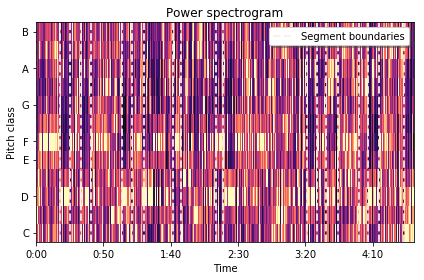

In [0]:
# Plot the segmentation over the chromagram
plt.figure()
librosa.display.specshow(chroma, y_axis='chroma', x_axis='time')
plt.vlines(bound_times, 0, chroma.shape[0], color='linen', linestyle='--',
            linewidth=2, alpha=0.9, label='Segment boundaries')
plt.axis('tight')
plt.legend(frameon=True, shadow=True)
plt.title('Power spectrogram')
plt.tight_layout()

###subsegment
[Ref link](https://librosa.github.io/librosa/generated/librosa.segment.subsegment.html#librosa-segment-subsegment)

Sub-divide a segmentation by feature clustering.

Given a set of frame boundaries (frames), and a data matrix (data), each successive interval defined by frames is partitioned into n_segments by constrained agglomerative clustering.

If an interval spans fewer than n_segments frames, then each frame becomes a sub-segment.

In [0]:
# Load audio, detect beat frames, and subdivide in twos by CQT
tempo, beats = librosa.beat.beat_track(y=y, sr=sr, hop_length=512)
beat_times = librosa.frames_to_time(beats, sr=sr, hop_length=512)
cqt = np.abs(librosa.cqt(y, sr=sr, hop_length=512))
subseg = librosa.segment.subsegment(cqt, beats, n_segments=2)
subseg_t = librosa.frames_to_time(subseg, sr=sr, hop_length=512)
subseg

In [0]:
plt.figure()
librosa.display.specshow(librosa.amplitude_to_db(cqt,ref=np.max),
                          y_axis='cqt_hz', x_axis='time')
lims = plt.gca().get_ylim()
plt.vlines(beat_times, lims[0], lims[1], color='lime', alpha=0.9,
            linewidth=2, label='Beats')
plt.vlines(subseg_t, lims[0], lims[1], color='linen', linestyle='--',
            linewidth=1.5, alpha=0.5, label='Sub-beats')
plt.legend(frameon=True, shadow=True)
plt.title('CQT + Beat and sub-beat markers')
plt.tight_layout()

##Sequential modeling
[Ref link](https://librosa.github.io/librosa/sequence.html#sequential-modeling)

##Dynamic time warping
[Ref link](https://librosa.github.io/librosa/sequence.html#dynamic-time-warping)

###dtw
[Ref link](https://librosa.github.io/librosa/generated/librosa.sequence.dtw.html#librosa-sequence-dtw)

Dynamic time warping (DTW).

This function performs a DTW and path backtracking on two sequences. We follow the nomenclature and algorithmic approach as described in [1].

In [0]:
X = librosa.feature.chroma_cens(y=y, sr=sr)
noise = np.random.rand(X.shape[0], 200)
Y = np.concatenate((noise, noise, X, noise), axis=1)
D, wp = librosa.sequence.dtw(X, Y, subseq=True)
plt.subplot(2, 1, 1)
librosa.display.specshow(D, x_axis='frames', y_axis='frames')
plt.title('Database excerpt')
plt.plot(wp[:, 1], wp[:, 0], label='Optimal path', color='y')
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(D[-1, :] / wp.shape[0])
plt.xlim([0, Y.shape[1]])
plt.ylim([0, 2])
plt.title('Matching cost function')
plt.tight_layout()

##Viterbi decoding
[Ref link](https://librosa.github.io/librosa/sequence.html#viterbi-decoding)

###viterbi
[Ref link](https://librosa.github.io/librosa/generated/librosa.sequence.viterbi.html#librosa-sequence-viterbi)

Viterbi decoding from observation likelihoods.

Given a sequence of observation likelihoods prob[s, t], indicating the conditional likelihood of seeing the observation at time t from state s, and a transition matrix transition[i, j] which encodes the conditional probability of moving from state i to state j, the Viterbi algorithm [1] computes the most likely sequence of states from the observations.

In [0]:
# Example from https://en.wikipedia.org/wiki/Viterbi_algorithm#Example

# In this example, we have two states healthy and fever, with initial probabilities 60% and 40%.

# We have three observation possibilities: normal, cold, and dizzy, whose probabilities given each state are:

# healthy => {normal: 50%, cold: 40%, dizzy: 10%} and fever => {normal: 10%, cold: 30%, dizzy: 60%}

# Finally, we have transition probabilities:

# healthy => healthy (70%) and fever => fever (60%).

# Over three days, we observe the sequence [normal, cold, dizzy], and wish to know the maximum likelihood assignment of states for the corresponding days, which we compute with the Viterbi algorithm below.
p_init = np.array([0.6, 0.4])
p_emit = np.array([[0.5, 0.4, 0.1],
                    [0.1, 0.3, 0.6]])
p_trans = np.array([[0.7, 0.3], [0.4, 0.6]])
path, logp = librosa.sequence.viterbi(p_emit, p_trans, p_init,
                                       return_logp=True)
print(logp, path)

###viterbi_discriminative
[Ref link](https://librosa.github.io/librosa/generated/librosa.sequence.viterbi_discriminative.html#librosa-sequence-viterbi-discriminative)

Viterbi decoding from discriminative state predictions.

Given a sequence of conditional state predictions prob[s, t], indicating the conditional likelihood of state s given the observation at time t, and a transition matrix transition[i, j] which encodes the conditional probability of moving from state i to state j, the Viterbi algorithm computes the most likely sequence of states from the observations.

This implementation uses the standard Viterbi decoding algorithm for observation likelihood sequences, under the assumption that P[Obs(t) | State(t) = s] is proportional to P[State(t) = s | Obs(t)] / P[State(t) = s], where the denominator is the marginal probability of state s occurring as given by p_state.

In [0]:
# This example constructs a simple, template-based discriminative chord estimator, using CENS chroma as input features.

# this chord model is not accurate enough to use in practice. It is only intended to demonstrate how to use discriminative Viterbi decoding.
# Create templates for major, minor, and no-chord qualities
maj_template = np.array([1,0,0, 0,1,0, 0,1,0, 0,0,0])
min_template = np.array([1,0,0, 1,0,0, 0,1,0, 0,0,0])
N_template   = np.array([1,1,1, 1,1,1, 1,1,1, 1,1,1.]) / 4.
# Generate the weighting matrix that maps chroma to labels
weights = np.zeros((25, 12), dtype=float)
labels = ['C:maj', 'C#:maj', 'D:maj', 'D#:maj', 'E:maj', 'F:maj',
           'F#:maj', 'G:maj', 'G#:maj', 'A:maj', 'A#:maj', 'B:maj',
           'C:min', 'C#:min', 'D:min', 'D#:min', 'E:min', 'F:min',
           'F#:min', 'G:min', 'G#:min', 'A:min', 'A#:min', 'B:min',
           'N']
for c in range(12):
     weights[c, :] = np.roll(maj_template, c) # c:maj
     weights[c + 12, :] = np.roll(min_template, c)  # c:min
weights[-1] = N_template  # the last row is the no-chord class
# Make a self-loop transition matrix over 25 states
trans = librosa.sequence.transition_loop(25, 0.9)

In [0]:
 # Load in audio and make features
chroma = librosa.feature.chroma_cens(y=y, sr=sr, bins_per_octave=36)
# Map chroma (observations) to class (state) likelihoods
probs = np.exp(weights.dot(chroma))  # P[class | chroma] proportional to exp(template' chroma)
probs /= probs.sum(axis=0, keepdims=True)  # probabilities must sum to 1 in each column
# Compute independent frame-wise estimates
chords_ind = np.argmax(probs, axis=0)
# And viterbi estimates
chords_vit = librosa.sequence.viterbi_discriminative(probs, trans)

In [0]:
# Plot the features and prediction map
plt.figure(figsize=(10, 6))
plt.subplot(2,1,1)
librosa.display.specshow(chroma, x_axis='time', y_axis='chroma')
plt.colorbar()
plt.subplot(2,1,2)
librosa.display.specshow(weights, x_axis='chroma')
plt.yticks(np.arange(25) + 0.5, labels)
plt.ylabel('Chord')
plt.colorbar()
plt.tight_layout()

In [0]:
# And plot the results
plt.figure(figsize=(10, 4))
librosa.display.specshow(probs, x_axis='time', cmap='gray')
plt.colorbar()
times = librosa.frames_to_time(np.arange(len(chords_vit)))
plt.scatter(times, chords_ind + 0.75, color='lime', alpha=0.5, marker='+', s=15, label='Independent')
plt.scatter(times, chords_vit + 0.25, color='deeppink', alpha=0.5, marker='o', s=15, label='Viterbi')
plt.yticks(0.5 + np.unique(chords_vit), [labels[i] for i in np.unique(chords_vit)], va='center')
plt.legend(loc='best')
plt.tight_layout()

###viterbi_binary
[Ref link](https://librosa.github.io/librosa/generated/librosa.sequence.viterbi_binary.html#librosa-sequence-viterbi-binary)

Viterbi decoding from binary (multi-label), discriminative state predictions.

Given a sequence of conditional state predictions prob[s, t], indicating the conditional likelihood of state s being active conditional on observation at time t, and a 2*2 transition matrix transition which encodes the conditional probability of moving from state s to state s (not-s), the Viterbi algorithm computes the most likely sequence of states from the observations.

This function differs from viterbi_discriminative in that it does not assume the states to be mutually exclusive. viterbi_binary is implemented by transforming the multi-label decoding problem to a collection of binary Viterbi problems (one for each state or label).

The output is a binary matrix states[s, t] indicating whether each state s is active at time t.

In [0]:
# Examples

# In this example, we have a sequence of binary state likelihoods that we want to de-noise under the assumption that state changes are relatively uncommon. Positive predictions should only be retained if they persist for multiple steps, and any transient predictions should be considered as errors. This use case arises frequently in problems such as instrument recognition, where state activations tend to be stable over time, but subject to abrupt changes (e.g., when an instrument joins the mix).

# We assume that the 0 state has a self-transition probability of 90%, and the 1 state has a self-transition probability of 70%. We assume the marginal and initial probability of either state is 50%.
trans = np.array([[0.9, 0.1], [0.3, 0.7]])
prob = np.array([0.1, 0.7, 0.4, 0.3, 0.8, 0.9, 0.8, 0.2, 0.6, 0.3])
librosa.sequence.viterbi_binary(prob, trans, p_state=0.5, p_init=0.5)

##Transition matrices
[Ref link](https://librosa.github.io/librosa/sequence.html#transition-matrices)

###transition_uniform
[Ref link](https://librosa.github.io/librosa/generated/librosa.sequence.transition_uniform.html#librosa-sequence-transition-uniform)

Construct a uniform transition matrix over n_states.

In [0]:
librosa.sequence.transition_uniform(3)

###transition_loop
[Ref link](https://librosa.github.io/librosa/generated/librosa.sequence.transition_loop.html#librosa-sequence-transition-loop)

Construct a self-loop transition matrix over n_states.

The transition matrix will have the following properties:

        transition[i, i] = p for all i
        transition[i, j] = (1 - p) / (n_states - 1) for all j != i

This type of transition matrix is appropriate when states tend to be locally stable, and there is no additional structure between different states. This is primarily useful for de-noising frame-wise predictions.

In [0]:
librosa.sequence.transition_loop(3, 0.5)

In [0]:
librosa.sequence.transition_loop(3, [0.8, 0.5, 0.25])

###transition_cycle
[Ref link](https://librosa.github.io/librosa/generated/librosa.sequence.transition_cycle.html#librosa-sequence-transition-cycle)

Construct a cyclic transition matrix over n_states.

The transition matrix will have the following properties:

        transition[i, i] = p
        transition[i, i + 1] = (1 - p)

This type of transition matrix is appropriate for state spaces with cyclical structure, such as metrical position within a bar. For example, a song in 4/4 time has state transitions of the form

    1->{1, 2}, 2->{2, 3}, 3->{3, 4}, 4->{4, 1}.

In [0]:
librosa.sequence.transition_cycle(4, 0.9)

###transition_local
[Ref link](https://librosa.github.io/librosa/generated/librosa.sequence.transition_local.html#librosa-sequence-transition-local)

Construct a localized transition matrix.

The transition matrix will have the following properties:

        transition[i, j] = 0 if |i - j| > width
        transition[i, i] is maximal
        transition[i, i - width//2 : i + width//2] has shape window

This type of transition matrix is appropriate for state spaces that discretely approximate continuous variables, such as in fundamental frequency estimation.

In [0]:
# Triangular distributions with and without wrapping
librosa.sequence.transition_local(5, 3, window='triangle', wrap=False)

In [0]:
librosa.sequence.transition_local(5, 3, window='triangle', wrap=True)

In [0]:
# Uniform local distributions with variable widths and no wrapping
librosa.sequence.transition_local(5, [1, 2, 3, 3, 1], window='ones', wrap=False)

##Filters
[Ref link](https://librosa.github.io/librosa/filters.html#id1)

##Filter bank construction
[Ref link](https://librosa.github.io/librosa/filters.html#filter-bank-construction)

###mel
[Ref link](https://librosa.github.io/librosa/generated/librosa.filters.mel.html#librosa-filters-mel)

Create a Filterbank matrix to combine FFT bins into Mel-frequency bins

In [0]:
melfb = librosa.filters.mel(22050, 2048)
melfb

In [0]:
# Clip the maximum frequency to 8KHz
librosa.filters.mel(22050, 2048, fmax=8000)

In [0]:
plt.figure()
librosa.display.specshow(melfb, x_axis='linear')
plt.ylabel('Mel filter')
plt.title('Mel filter bank')
plt.colorbar()
plt.tight_layout()

###chroma
[Ref link](https://librosa.github.io/librosa/generated/librosa.filters.chroma.html#librosa-filters-chroma)

Create a Filterbank matrix to convert STFT to chroma

In [0]:
# Build a simple chroma filter bank
chromafb = librosa.filters.chroma(22050, 4096)

In [0]:
# Use quarter-tones instead of semitones
librosa.filters.chroma(22050, 4096, n_chroma=24)

In [0]:
# Equally weight all octaves
librosa.filters.chroma(22050, 4096, octwidth=None)

In [0]:
plt.figure()
librosa.display.specshow(chromafb, x_axis='linear')
plt.ylabel('Chroma filter')
plt.title('Chroma filter bank')
plt.colorbar()
plt.tight_layout()

###constant_q
[Ref link](https://librosa.github.io/librosa/generated/librosa.filters.constant_q.html#librosa-filters-constant-q)

Construct a constant-Q basis.

This uses the filter bank described by [1].

In [0]:
# Use a shorter window for each filter
basis, lengths = librosa.filters.constant_q(22050, filter_scale=0.5)

In [0]:
# Plot one octave of filters in time and frequency
basis, lengths = librosa.filters.constant_q(22050)
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
notes = librosa.midi_to_note(np.arange(24, 24 + len(basis)))
for i, (f, n) in enumerate(zip(basis, notes[:12])):
     f_scale = librosa.util.normalize(f) / 2
     plt.plot(i + f_scale.real)
     plt.plot(i + f_scale.imag, linestyle=':')
plt.axis('tight')
plt.yticks(np.arange(len(notes[:12])), notes[:12])
plt.ylabel('CQ filters')
plt.title('CQ filters (one octave, time domain)')
plt.xlabel('Time (samples at 22050 Hz)')
plt.legend(['Real', 'Imaginary'], frameon=True, framealpha=0.8)
plt.subplot(2, 1, 2)
F = np.abs(np.fft.fftn(basis, axes=[-1]))
# Keep only the positive frequencies
F = F[:, :(1 + F.shape[1] // 2)]
librosa.display.specshow(F, x_axis='linear')
plt.yticks(np.arange(len(notes))[::12], notes[::12])
plt.ylabel('CQ filters')
plt.title('CQ filter magnitudes (frequency domain)')
plt.tight_layout()

###_multirate_fb
[Ref link](https://librosa.github.io/librosa/generated/librosa.filters._multirate_fb.html#librosa-filters-multirate-fb)

Helper function to construct a multirate filterbank.

    A filter bank consists of multiple band-pass filters which divide the input signal into subbands. In the case of a multirate filter bank, the band-pass filters operate with resampled versions of the input signal, e.g. to keep the length of a filter constant while shifting its center frequency.

    This implementation uses scipy.signal.iirdesign to design the filters.

In [0]:
#No example provided

###semitone_filterbank
[Ref link](https://librosa.github.io/librosa/generated/librosa.filters.semitone_filterbank.html#librosa-filters-semitone-filterbank)

Constructs a multirate filterbank of infinite-impulse response (IIR) band-pass filters at user-defined center frequencies and sample rates.

By default, these center frequencies are set equal to the 88 fundamental frequencies of the grand piano keyboard, according to a pitch tuning standard of A440, that is, note A above middle C set to 440 Hz. The center frequencies are tuned to the twelve-tone equal temperament, which means that they grow exponentially at a rate of 2**(1/12), that is, twelve notes per octave.

The A440 tuning can be changed by the user while keeping twelve-tone equal temperament. While A440 is currently the international standard in the music industry (ISO 16), some orchestras tune to A441-A445, whereas baroque musicians tune to A415.

See [1] for details.

In [0]:
import scipy.signal
semitone_filterbank, sample_rates = librosa.filters.semitone_filterbank()
plt.figure(figsize=(10, 6))
for cur_sr, cur_filter in zip(sample_rates, semitone_filterbank):
    w, h = scipy.signal.freqz(cur_filter[0], cur_filter[1], worN=2000)
    plt.plot((cur_sr / (2 * np.pi)) * w, 20 * np.log10(abs(h)))
plt.semilogx()
plt.xlim([20, 10e3])
plt.ylim([-60, 3])
plt.title('Magnitude Responses of the Pitch Filterbank')
plt.xlabel('Log-Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.tight_layout()

##Window functions
[Ref link](https://librosa.github.io/librosa/filters.html#window-functions)

###window_bandwidth
[Ref link](https://librosa.github.io/librosa/generated/librosa.filters.window_bandwidth.html#librosa-filters-window-bandwidth)

Get the equivalent noise bandwidth of a window function.

In [0]:
# No example provided

###get_window
[Ref link](https://librosa.github.io/librosa/generated/librosa.filters.get_window.html#librosa-filters-get-window)

Compute a window function.

This is a wrapper for scipy.signal.get_window that additionally supports callable or pre-computed windows.

In [0]:
# No example provided

##Miscellaneous
[Ref link](https://librosa.github.io/librosa/filters.html#miscellaneous)

###constant_q_lengths
[Ref link](https://librosa.github.io/librosa/generated/librosa.filters.constant_q_lengths.html#librosa-filters-constant-q-lengths)

Return length of each filter in a constant-Q basis.

In [0]:
# No example provided

###cq_to_chroma
[Ref link](https://librosa.github.io/librosa/generated/librosa.filters.cq_to_chroma.html#librosa-filters-cq-to-chroma)

Convert a Constant-Q basis to Chroma.

In [0]:
# Get a CQT, and wrap bins to chroma
CQT = np.abs(librosa.cqt(y, sr=sr))
chroma_map = librosa.filters.cq_to_chroma(CQT.shape[0])
chromagram = chroma_map.dot(CQT)
# Max-normalize each time step
chromagram = librosa.util.normalize(chromagram, axis=0)

In [0]:
plt.subplot(3, 1, 1)
librosa.display.specshow(librosa.amplitude_to_db(CQT,
                                                  ref=np.max),
                          y_axis='cqt_note')
plt.title('CQT Power')
plt.colorbar()
plt.subplot(3, 1, 2)
librosa.display.specshow(chromagram, y_axis='chroma')
plt.title('Chroma (wrapped CQT)')
plt.colorbar()
plt.subplot(3, 1, 3)
chroma = librosa.feature.chroma_stft(y=y, sr=sr)
librosa.display.specshow(chroma, y_axis='chroma', x_axis='time')
plt.title('librosa.feature.chroma_stft')
plt.colorbar()
plt.tight_layout()

###mr_frequencies
[Ref link](https://librosa.github.io/librosa/generated/librosa.filters.mr_frequencies.html#librosa-filters-mr-frequencies)

Helper function for generating center frequency and sample rate pairs.

This function will return center frequency and corresponding sample rates to obtain similar pitch filterbank settings as described in [1]. Instead of starting with MIDI pitch A0, we start with C0.

In [0]:
# No example provided

###window_sumsquare
[Ref link](https://librosa.github.io/librosa/generated/librosa.filters.window_sumsquare.html#librosa-filters-window-sumsquare)

Compute the sum-square envelope of a window function at a given hop length.

This is used to estimate modulation effects induced by windowing observations in short-time fourier transforms.

In [0]:
# For a fixed frame length (2048), compare modulation effects for a Hann window at different hop lengths:
n_frames = 50
wss_256 = librosa.filters.window_sumsquare('hann', n_frames, hop_length=256)
wss_512 = librosa.filters.window_sumsquare('hann', n_frames, hop_length=512)
wss_1024 = librosa.filters.window_sumsquare('hann', n_frames, hop_length=1024)

In [0]:
plt.figure()
plt.subplot(3,1,1)
plt.plot(wss_256)
plt.title('hop_length=256')
plt.subplot(3,1,2)
plt.plot(wss_512)
plt.title('hop_length=512')
plt.subplot(3,1,3)
plt.plot(wss_1024)
plt.title('hop_length=1024')
plt.tight_layout()

##Utilities
[Ref link](https://librosa.github.io/librosa/util.html#utilities)

##Array operations
[Ref link](https://librosa.github.io/librosa/util.html#array-operations)

###frame
[Ref link](https://librosa.github.io/librosa/generated/librosa.util.frame.html#librosa-util-frame)

Slice a time series into overlapping frames.

This implementation uses low-level stride manipulation to avoid redundant copies of the time series data.

In [0]:
librosa.util.frame(y, frame_length=2048, hop_length=64)

###pad_center
[Ref link](https://librosa.github.io/librosa/generated/librosa.util.pad_center.html#librosa-util-pad-center)

Wrapper for np.pad to automatically center an array prior to padding. This is analogous to str.center()

In [0]:
# Generate a vector
data = np.ones(5)
librosa.util.pad_center(data, 10, mode='constant')

In [0]:
# Pad a matrix along its first dimension
data = np.ones((3, 5))
librosa.util.pad_center(data, 7, axis=0)

In [0]:
# Or its second dimension
librosa.util.pad_center(data, 7, axis=1)

###fix_length
[Ref link](https://librosa.github.io/librosa/generated/librosa.util.fix_length.html#librosa-util-fix-length)

Fix the length an array data to exactly size.

If data.shape[axis] < n, pad according to the provided kwargs. By default, data is padded with trailing zeros.

In [0]:
y = np.arange(7)
# Default: pad with zeros
librosa.util.fix_length(y, 10)

# Trim to a desired length
librosa.util.fix_length(y, 5)

# Use edge-padding instead of zeros
librosa.util.fix_length(y, 10, mode='edge')

###fix_frames
[Ref link](https://librosa.github.io/librosa/generated/librosa.util.fix_frames.html#librosa-util-fix-frames)

Fix a list of frames to lie within [x_min, x_max]

In [0]:
# Generate a list of frame indices
frames = np.arange(0, 1000.0, 50)
frames

# Clip to span at most 250
librosa.util.fix_frames(frames, x_max=250)

# Or pad to span up to 2500
librosa.util.fix_frames(frames, x_max=2500)

librosa.util.fix_frames(frames, x_max=2500, pad=False)

In [0]:
# Or starting away from zero
frames = np.arange(200, 500, 33)
frames

librosa.util.fix_frames(frames)

librosa.util.fix_frames(frames, x_max=500)

###index_to_slice
[Ref link](https://librosa.github.io/librosa/generated/librosa.util.index_to_slice.html#librosa-util-index-to-slice)

Generate a slice array from an index array.

In [0]:
# Generate slices from spaced indices
librosa.util.index_to_slice(np.arange(20, 100, 15))

# Pad to span the range (0, 100)
librosa.util.index_to_slice(np.arange(20, 100, 15),
                             idx_min=0, idx_max=100)

# Use a step of 5 for each slice
librosa.util.index_to_slice(np.arange(20, 100, 15),
                             idx_min=0, idx_max=100, step=5)

###softmask
[Ref link](https://librosa.github.io/librosa/generated/librosa.util.softmask.html#librosa-util-softmask)

Robustly compute a softmask operation.

    M = X**power / (X**power + X_ref**power)

In [0]:
X = 2 * np.ones((3, 3))
X_ref = np.vander(np.arange(3.0))
X

X_ref

librosa.util.softmask(X, X_ref, power=1)

librosa.util.softmask(X_ref, X, power=1)

librosa.util.softmask(X, X_ref, power=2)

librosa.util.softmask(X, X_ref, power=4)

librosa.util.softmask(X, X_ref, power=100)

librosa.util.softmask(X, X_ref, power=np.inf)

###sync
[Ref link](https://librosa.github.io/librosa/generated/librosa.util.sync.html#librosa-util-sync)

Synchronous aggregation of a multi-dimensional array between boundaries



Note

In order to ensure total coverage, boundary points may be added to idx.

If synchronizing a feature matrix against beat tracker output, ensure that frame index numbers are properly aligned and use the same hop length.

In [0]:
# Beat-synchronous CQT spectra
y, sr = librosa.load(librosa.util.example_audio_file())
tempo, beats = librosa.beat.beat_track(y=y, sr=sr, trim=False)
C = np.abs(librosa.cqt(y=y, sr=sr))
beats = librosa.util.fix_frames(beats, x_max=C.shape[1])

In [0]:
# By default, use mean aggregation
C_avg = librosa.util.sync(C, beats)

In [0]:
# Use median-aggregation instead of mean
C_med = librosa.util.sync(C, beats, aggregate=np.median)

In [0]:
# Or sub-beat synchronization
sub_beats = librosa.segment.subsegment(C, beats)
sub_beats = librosa.util.fix_frames(sub_beats, x_max=C.shape[1])
C_med_sub = librosa.util.sync(C, sub_beats, aggregate=np.median)

In [0]:
# Plot the results
beat_t = librosa.frames_to_time(beats, sr=sr)
subbeat_t = librosa.frames_to_time(sub_beats, sr=sr)
plt.figure()
plt.subplot(3, 1, 1)
librosa.display.specshow(librosa.amplitude_to_db(C,ref=np.max), x_axis='time')
plt.title('CQT power, shape={}'.format(C.shape))
plt.subplot(3, 1, 2)
librosa.display.specshow(librosa.amplitude_to_db(C_med, ref=np.max), x_coords=beat_t, x_axis='time')
plt.title('Beat synchronous CQT power, '
          'shape={}'.format(C_med.shape))
plt.subplot(3, 1, 3)
librosa.display.specshow(librosa.amplitude_to_db(C_med_sub, ref=np.max), x_coords=subbeat_t, x_axis='time')
# plt.title('Sub-beat synchronous CQT power, ' 'shape={}'.format(cqt_med_sub.shape)) #this line cause an exception
plt.tight_layout()

###axis_sort
[Ref link](https://librosa.github.io/librosa/generated/librosa.util.axis_sort.html#librosa-util-axis-sort)

Sort an array along its rows or columns.

In [0]:
# Visualize NMF output for a spectrogram S
# Sort the columns of W by peak frequency bin
S = np.abs(librosa.stft(y))
W, H = librosa.decompose.decompose(S, n_components=32)
W_sort = librosa.util.axis_sort(W)

In [0]:
# Or sort by the lowest frequency bin
W_sort = librosa.util.axis_sort(W, value=np.argmin)

In [0]:
# Or sort the rows instead of the columns
W_sort_rows = librosa.util.axis_sort(W, axis=0)

In [0]:
# Get the sorting index also, and use it to permute the rows of H
W_sort, idx = librosa.util.axis_sort(W, index=True)
H_sort = H[idx, :]

In [0]:
plt.figure()
plt.subplot(2, 2, 1)
librosa.display.specshow(librosa.amplitude_to_db(W, ref=np.max), y_axis='log')
plt.title('W')
plt.subplot(2, 2, 2)
librosa.display.specshow(H, x_axis='time')
plt.title('H')
plt.subplot(2, 2, 3)
librosa.display.specshow(librosa.amplitude_to_db(W_sort, ref=np.max), y_axis='log')
plt.title('W sorted')
plt.subplot(2, 2, 4)
librosa.display.specshow(H_sort, x_axis='time')
plt.title('H sorted')
plt.tight_layout()


###normalize
[Ref link](https://librosa.github.io/librosa/generated/librosa.util.normalize.html#librosa-util-normalize)

Normalize an array along a chosen axis.

Given a norm (described below) and a target axis, the input array is scaled so that

    norm(S, axis=axis) == 1

For example, axis=0 normalizes each column of a 2-d array by aggregating over the rows (0-axis). Similarly, axis=1 normalizes each row of a 2-d array.

This function also supports thresholding small-norm slices: any slice (i.e., row or column) with norm below a specified threshold can be left un-normalized, set to all-zeros, or filled with uniform non-zero values that normalize to 1.

Note: the semantics of this function differ from scipy.linalg.norm in two ways: multi-dimensional arrays are supported, but matrix-norms are not.

In [0]:
# Construct an example matrix
S = np.vander(np.arange(-2.0, 2.0))
S

# Max (l-infinity)-normalize the columns
librosa.util.normalize(S)

# Max (l-infinity)-normalize the rows
librosa.util.normalize(S, axis=1)

# l1-normalize the columns
librosa.util.normalize(S, norm=1)

# l2-normalize the columns
librosa.util.normalize(S, norm=2)

In [0]:
# Thresholding and filling
S[:, -1] = 1e-308
S

In [0]:
# By default, small-norm columns are left untouched
librosa.util.normalize(S)

# Small-norm columns can be zeroed out
librosa.util.normalize(S, fill=False)

# Or set to constant with unit-norm
librosa.util.normalize(S, fill=True)

# With an l1 norm instead of max-norm
librosa.util.normalize(S, norm=1, fill=True)

###roll_sparse
[Ref link](https://librosa.github.io/librosa/generated/librosa.util.roll_sparse.html#librosa-util-roll-sparse)

Sparse matrix roll

This operation is equivalent to numpy.roll, but operates on sparse matrices.

In [0]:
# Generate a random sparse binary matrix
X = scipy.sparse.lil_matrix(np.random.randint(0, 2, size=(5,5)))
X_roll = librosa.util.roll_sparse(X, 2, axis=0)  # Roll by 2 on the first axis
X_dense_r = librosa.util.roll_sparse(X.toarray(), 2, axis=0)  # Equivalent dense roll
np.allclose(X_roll, X_dense_r.toarray()) #this line throws and exception

###sparsify_rows
[Ref link](https://librosa.github.io/librosa/generated/librosa.util.sparsify_rows.html#librosa-util-sparsify-rows)

Return a row-sparse matrix approximating the input x.

In [0]:
# Construct a Hann window to sparsify
x = scipy.signal.hann(32)
x

# Discard the bottom percentile
x_sparse = librosa.util.sparsify_rows(x, quantile=0.01)
x_sparse

x_sparse.todense()

# Discard up to the bottom 10th percentile
x_sparse = librosa.util.sparsify_rows(x, quantile=0.1)
x_sparse

x_sparse.todense()

###buf_to_float
[Ref link](https://librosa.github.io/librosa/generated/librosa.util.buf_to_float.html#librosa-util-buf-to-float)

Convert an integer buffer to floating point values. This is primarily useful when loading integer-valued wav data into numpy arrays.

In [0]:
# No example code provided

###tiny
[Ref link](https://librosa.github.io/librosa/generated/librosa.util.tiny.html#librosa-util-tiny)

Compute the tiny-value corresponding to an input’s data type.

This is the smallest “usable” number representable in x’s data type (e.g., float32).

This is primarily useful for determining a threshold for numerical underflow in division or multiplication operations.

In [0]:
# For a standard double-precision floating point number:
librosa.util.tiny(1.0)

In [0]:
# Or explicitly as double-precision
librosa.util.tiny(np.asarray(1e-5, dtype=np.float64))

In [0]:
# Or complex numbers
librosa.util.tiny(1j)

In [0]:
# Single-precision floating point:
librosa.util.tiny(np.asarray(1e-5, dtype=np.float32))

In [0]:
# Integer
librosa.util.tiny(5)

##Matching
[Ref link](https://librosa.github.io/librosa/util.html#matching)

###match_intervals
[Ref link](https://librosa.github.io/librosa/generated/librosa.util.match_intervals.html#librosa-util-match-intervals)

Match one set of time intervals to another.

This can be useful for tasks such as mapping beat timings to segments.

Each element [a, b] of intervals_from is matched to the element [c, d] of intervals_to which maximizes the Jaccard similarity between the intervals:

    max(0, |min(b, d) - max(a, c)|) / |max(d, b) - min(a, c)|

In strict=True mode, if there is no interval with positive intersection with [a,b], an exception is thrown.

In strict=False mode, any interval [a, b] that has no intersection with any element of intervals_to is instead matched to the interval [c, d] which minimizes

    min(|b - c|, |a - d|)

that is, the disjoint interval [c, d] with a boundary closest to [a, b].


Note

An element of intervals_to may be matched to multiple entries of intervals_from.

In [0]:
ints_from = np.array([[3, 5], [1, 4], [4, 5]])
ints_to = np.array([[0, 2], [1, 3], [4, 5], [6, 7]])
librosa.util.match_intervals(ints_from, ints_to)

# [3, 5] => [4, 5]  (ints_to[2])
# [1, 4] => [1, 3]  (ints_to[1])
# [4, 5] => [4, 5]  (ints_to[2])

The reverse matching of the above is not possible in strict mode because [6, 7] is disjoint from all intervals in ints_from. With strict=False, we get the following: >>> librosa.util.match_intervals(ints_to, ints_from, strict=False) array([1, 1, 2, 2], dtype=uint32) >>> # [0, 2] => [1, 4] (ints_from[1]) >>> # [1, 3] => [1, 4] (ints_from[1]) >>> # [4, 5] => [4, 5] (ints_from[2]) >>> # [6, 7] => [4, 5] (ints_from[2])

###match_events
[Ref link](https://librosa.github.io/librosa/generated/librosa.util.match_events.html#librosa-util-match-events)

Match one set of events to another.

This is useful for tasks such as matching beats to the nearest detected onsets, or frame-aligned events to the nearest zero-crossing.


Note

A target event may be matched to multiple source events.

In [44]:
# Sources are multiples of 7
s_from = np.arange(0, 100, 7)
s_from

# Targets are multiples of 10
s_to = np.arange(0, 100, 10)
s_to

# Find the matching
idx = librosa.util.match_events(s_from, s_to)
idx

# Print each source value to its matching target
zip(s_from, s_to[idx])

##Miscellaneous
[Ref link](https://librosa.github.io/librosa/util.html#miscellaneous)

###localmax
[Ref link](https://librosa.github.io/librosa/generated/librosa.util.localmax.html#librosa-util-localmax)

Find local maxima in an array x.

An element x[i] is considered a local maximum if the following conditions are met:

    x[i] > x[i-1]
    x[i] >= x[i+1]

Note that the first condition is strict, and that the first element x[0] will never be considered as a local maximum.

In [0]:
x = np.array([1, 0, 1, 2, -1, 0, -2, 1])
librosa.util.localmax(x)

In [0]:
# Two-dimensional example
x = np.array([[1,0,1], [2, -1, 0], [2, 1, 3]])
librosa.util.localmax(x, axis=0)

librosa.util.localmax(x, axis=1)

###peak_pick
[Ref link](https://librosa.github.io/librosa/generated/librosa.util.peak_pick.html#librosa-util-peak-pick)

Uses a flexible heuristic to pick peaks in a signal.

A sample n is selected as an peak if the corresponding x[n] fulfills the following three conditions:

    x[n] == max(x[n - pre_max:n + post_max])
    x[n] >= mean(x[n - pre_avg:n + post_avg]) + delta
    n - previous_n > wait

where previous_n is the last sample picked as a peak (greedily).

This implementation is based on [1] and [2].

In [0]:
onset_env = librosa.onset.onset_strength(y=y, sr=sr, hop_length=512, aggregate=np.median)
peaks = librosa.util.peak_pick(onset_env, 3, 3, 3, 5, 0.5, 10)
peaks

In [0]:
times = librosa.frames_to_time(np.arange(len(onset_env)),
                                sr=sr, hop_length=512)
plt.figure()
ax = plt.subplot(2, 1, 2)
D = librosa.stft(y)
librosa.display.specshow(librosa.amplitude_to_db(D, ref=np.max),
                          y_axis='log', x_axis='time')
plt.subplot(2, 1, 1, sharex=ax)
plt.plot(times, onset_env, alpha=0.8, label='Onset strength')
plt.vlines(times[peaks], 0,
            onset_env.max(), color='r', alpha=0.8,
            label='Selected peaks')
plt.legend(frameon=True, framealpha=0.8)
plt.axis('tight')
plt.tight_layout()

##Input validation
[Ref link](https://librosa.github.io/librosa/util.html#input-validation)

###valid_audio
[Ref link](https://librosa.github.io/librosa/generated/librosa.util.valid_audio.html#librosa-util-valid-audio)

Validate whether a variable contains valid, mono audio data.

In [0]:
# Only allow monophonic signals
librosa.util.valid_audio(y)

In [0]:
# If we want to allow stereo signals
y, sr = librosa.load(librosa.util.example_audio_file(), mono=False)
librosa.util.valid_audio(y, mono=False)

###valid_int
[Ref link](https://librosa.github.io/librosa/generated/librosa.util.valid_int.html#librosa-util-valid-int)

Ensure that an input value is integer-typed. This is primarily useful for ensuring integrable-valued array indices.

In [0]:
# No example code provided

###valid_intervals
[Ref link](https://librosa.github.io/librosa/generated/librosa.util.valid_intervals.html#librosa-util-valid-intervals)

Ensure that an array is a valid representation of time intervals:

        intervals.ndim == 2
        intervals.shape[1] == 2
        intervals[i, 0] <= intervals[i, 1] for all i

In [0]:
# No example code provided

##File operations
[Ref link](https://librosa.github.io/librosa/util.html#file-operations)

###example_audio_file
[Ref link](https://librosa.github.io/librosa/generated/librosa.util.example_audio_file.html#librosa-util-example-audio-file)

Get the path to an included audio example file.

In [0]:
# Load the waveform from the example track
y, sr = librosa.load(librosa.util.example_audio_file())

##find_files
[Ref link](https://librosa.github.io/librosa/generated/librosa.util.find_files.html#librosa-util-find-files)

Get a sorted list of (audio) files in a directory or directory sub-tree.

In [0]:
# Get all audio files in a directory sub-tree
files = librosa.util.find_files('~/Music')

In [0]:
 # Look only within a specific directory, not the sub-tree
files = librosa.util.find_files('~/Music', recurse=False)

In [0]:
# Only look for mp3 files
files = librosa.util.find_files('~/Music', ext='mp3')

In [0]:
# Or just mp3 and ogg
files = librosa.util.find_files('~/Music', ext=['mp3', 'ogg'])

In [0]:
# Only get the first 10 files
files = librosa.util.find_files('~/Music', limit=10)

In [0]:
# Or last 10 files
files = librosa.util.find_files('~/Music', offset=-10)

##Plot spectrum FFT

[Ref link](https://librosa.github.io/librosa/generated/librosa.feature.chroma_stft.html#librosa-feature-chroma-stft)



In [0]:
#Spectrum Analysis - fourier transform and frequency domain
# Ref:https://makersportal.com/blog/2018/9/13/audio-processing-in-python-part-i-sampling-and-the-fast-fourier-transform
Y_k = np.fft.fft(y)

In [0]:
# sampling information
Fs = sr # sample rate
T = 1/Fs # sampling period
t = librosa.get_duration(y=y, sr=sr) # seconds of sampling
N = Fs*t-1 # total points in signal

f = Fs*np.arange((N/2))/N; # frequency vector

Y_k = Y_k[0:int(N/2)]/N # FFT function from numpy
Y_k[1:] = 2*Y_k[1:] # need to take the single-sided spectrum only
Pxx = np.abs(Y_k) # be sure to get rid of imaginary part


# print(Pxx)

In [0]:
# Adjust plot size
plt.rcParams['figure.figsize'] = [20, 10]
# plotting
fig,ax = plt.subplots()
plt.plot(f,Pxx,linewidth=1)
ax.set_xscale('log')
ax.set_yscale('log')
plt.ylabel('Amplitude')
plt.xlabel('Frequency [Hz]')
plt.grid(True, which='both')
plt.xlim([.3,10000]) #limit range of X axis
plt.show()